In [ ]:
# Examination of olink assay annotations for potential error modes / batch effects

In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve,auc 
from sklearn.linear_model import LogisticRegression, LinearRegression

# Load and merge data tables

In [2]:
# read in saved PTVs dataframe
ptvs = pd.read_csv('/home/jupyter/gcs/ukb/regenie/gwas_annotated/ptvs.txt', sep='\t')

/var/tmp/ipykernel_37954/1408193095.py:2: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  ptvs = pd.read_csv('/home/jupyter/gcs/ukb/regenie/gwas_annotated/ptvs.txt', sep='\t')


In [3]:
# Read in olink protein assay annotations table
annot = pd.read_csv('/home/jupyter/gcs/ukb/npx/olink_supp2.csv')

In [4]:
# rename protein symbol column from 'Assay' to 'symbol' to use as key for merging with ptvs table
annot.rename({"Assay":"symbol"}, axis=1, inplace=True)

In [5]:
ptvs_m = pd.merge(ptvs, annot, how='inner', on='symbol')

In [6]:
# export merged dataframe for easier use later
ptvs_m.to_csv('/home/jupyter/gcs/ukb/regenie/gwas_annotated/ptvs_olink.txt', sep='\t')

In [7]:
len(annot)

2958

In [8]:
len(annot['symbol'].unique())

2923

In [9]:
len(annot)-len(annot['symbol'].unique())

35

In [10]:
x = annot.sort_values('symbol')
x.loc[x.duplicated('symbol', keep=False),:]

,symbol,Study HGNC,UKBPPP_ProteinID,olink_target_fullname,OlinkID,UniProt,Assay.1,Panel,UniProt2,HGNC.symbol,ensembl_id,chr,gene_start,gene_end,Strand,Dilution_factor,block,Version
112,AMY1A_AMY1B_AMY1C,AMY1B,AMY1A_AMY1B_AMY1C:P0DUB6_P0DTE7_P0DTE8:OID3070...,Alpha-amylase 1A_Alpha-amylase 1B_Alpha-amylas...,OID30707,P0DUB6_P0DTE7_P0DTE8,AMY1A_AMY1B_AMY1C,Inflammation_II,P0DTE7,AMY1B,ENSG00000174876,1,103687415,103696454,-1,1:1000,C,expand
113,AMY1A_AMY1B_AMY1C,AMY1C,AMY1A_AMY1B_AMY1C:P0DUB6_P0DTE7_P0DTE8:OID3070...,Alpha-amylase 1A_Alpha-amylase 1B_Alpha-amylas...,OID30707,P0DUB6_P0DTE7_P0DTE8,AMY1A_AMY1B_AMY1C,Inflammation_II,P0DTE8,AMY1C,ENSG00000187733,1,103745323,103758726,1,1:1000,C,expand
111,AMY1A_AMY1B_AMY1C,AMY1A,AMY1A_AMY1B_AMY1C:P0DUB6_P0DTE7_P0DTE8:OID3070...,Alpha-amylase 1A_Alpha-amylase 1B_Alpha-amylas...,OID30707,P0DUB6_P0DTE7_P0DTE8,AMY1A_AMY1B_AMY1C,Inflammation_II,P0DUB6,AMY1A,ENSG00000237763,1,103655760,103664554,1,1:1000,C,expand
2925,BOLA2_BOLA2B,.,BOLA2_BOLA2B:Q9H3K6:OID30267:v1,BolA-like protein 2,OID30267,Q9H3K6,BOLA2_BOLA2B,Cardiometabolic_II,Q9H3K6,BOLA2B,ENSG00000169627,16,30192932,30194306,-1,1:1,B,expand
274,BOLA2_BOLA2B,BOLA2,BOLA2_BOLA2B:Q9H3K6:OID30267:v1,BolA-like protein 2,OID30267,Q9H3K6,BOLA2_BOLA2B,Cardiometabolic_II,Q9H3K6,BOLA2,ENSG00000183336,16,29453590,29454351,-1,1:1,B,expand
549,CGB3_CGB5_CGB8,CGB8,CGB3_CGB5_CGB8:P0DN86:OID30671:v1,Choriogonadotropin subunit beta 3,OID30671,P0DN86,CGB3_CGB5_CGB8,Inflammation_II,P0DN86,CGB8,ENSG00000213030,19,49047638,49049111,-1,1:1000,C,expand
548,CGB3_CGB5_CGB8,CGB5,CGB3_CGB5_CGB8:P0DN86:OID30671:v1,Choriogonadotropin subunit beta 3,OID30671,P0DN86,CGB3_CGB5_CGB8,Inflammation_II,P0DN86,CGB5,ENSG00000189052,19,49043848,49045311,1,1:1000,C,expand
547,CGB3_CGB5_CGB8,CGB3,CGB3_CGB5_CGB8:P0DN86:OID30671:v1,Choriogonadotropin subunit beta 3,OID30671,P0DN86,CGB3_CGB5_CGB8,Inflammation_II,P0DN86,CGB3,ENSG00000104827,19,49022869,49024333,-1,1:1000,C,expand
576,CKMT1A_CKMT1B,CKMT1A,CKMT1A_CKMT1B:P12532:OID20721:v1,"Creatine kinase U-type, mitochondrial",OID20721,P12532,CKMT1A_CKMT1B,Inflammation,P12532,CKMT1A,ENSG00000223572,15,43692886,43699222,1,1:10,D,explore
577,CKMT1A_CKMT1B,CKMT1B,CKMT1A_CKMT1B:P12532:OID20721:v1,"Creatine kinase U-type, mitochondrial",OID20721,P12532,CKMT1A_CKMT1B,Inflammation,P12532,CKMT1B,ENSG00000237289,15,43593054,43604901,1,1:10,D,explore


In [11]:
len(annot.loc[annot.duplicated('symbol', keep=False),'symbol'].unique())

21

# Breakdown by Olink Panel

In [12]:
# read in saved merged dataframe
ptvs_m = pd.read_csv('/home/jupyter/gcs/ukb/regenie/gwas_annotated/ptvs_olink.txt', sep='\t')

/var/tmp/ipykernel_37954/1204955267.py:2: DtypeWarning: Columns (40,103) have mixed types. Specify dtype option on import or set low_memory=False.
  ptvs_m = pd.read_csv('/home/jupyter/gcs/ukb/regenie/gwas_annotated/ptvs_olink.txt', sep='\t')


In [13]:
# Number of different proteins analyzed with each olink panel
anno_grp = annot.groupby('Panel')
anno_grp['symbol'].count()

Panel
Cardiometabolic       370
Cardiometabolic_II    368
Inflammation          370
Inflammation_II       373
Neurology             368
Neurology_II          368
Oncology              372
Oncology_II           369
Name: symbol, dtype: int64

In [14]:
# Variant count and beta breakdown for each panel
panel_grp = ptvs_m.groupby('Panel')
sorted_grp = panel_grp['BETA'].median().sort_values()
custom_order = sorted_grp.index.tolist()
ptvs_m['Panel'] = pd.Categorical(ptvs_m['Panel'], categories=custom_order, ordered=True)
panel_grp = ptvs_m.groupby('Panel', observed=True)
panel_grp['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
Panel,,,,,,,,
Cardiometabolic,3591.0,-1.382192,1.374560,-4.48307,-2.425625,-1.532250,-0.476969,4.44317
Neurology,3209.0,-1.162947,1.342484,-4.41930,-2.139750,-1.223500,-0.259808,4.32518
Inflammation_II,3414.0,-1.115206,1.316238,-4.45087,-2.130883,-1.165385,-0.172500,4.21225
Inflammation,3083.0,-1.103063,1.329516,-4.40800,-2.049845,-1.148750,-0.226528,4.65809
Oncology,3183.0,-1.024554,1.309586,-4.40498,-1.966515,-1.024980,-0.156585,4.30413
Cardiometabolic_II,3845.0,-0.706676,1.213616,-4.16646,-1.542750,-0.627740,0.107081,4.53685
Neurology_II,3023.0,-0.418250,1.075195,-3.92203,-1.124580,-0.337482,0.279019,3.72969
Oncology_II,3517.0,-0.370299,1.072854,-3.69865,-1.024060,-0.303204,0.293165,4.09682


In [15]:
sns.set()

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='BETA', ylabel='Panel'>

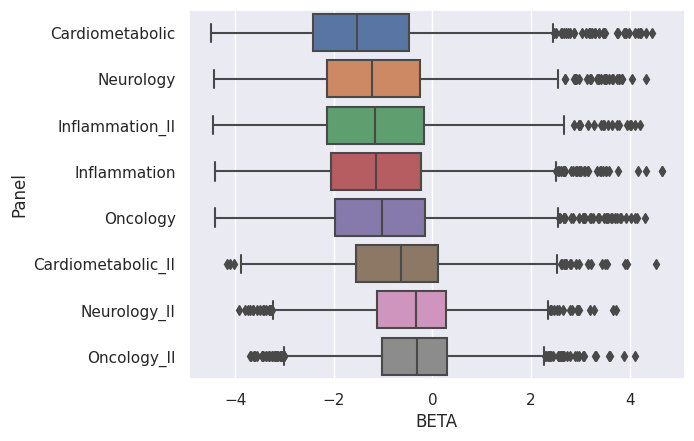

In [16]:
sns.boxplot(data=ptvs_m, y='Panel', x='BETA')

Text(0, 0.5, 'loss of function (%)')

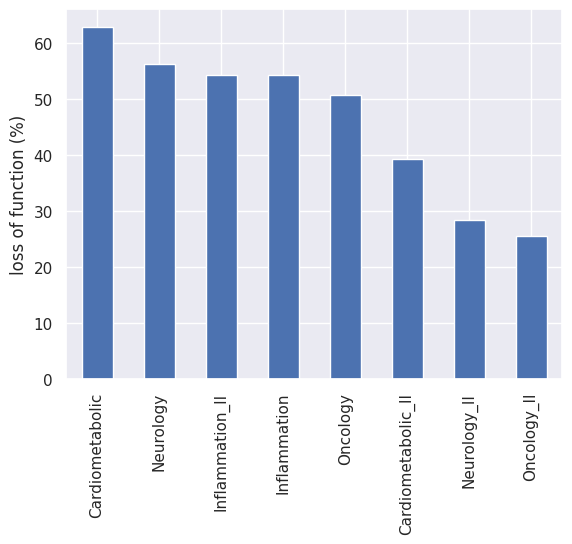

In [17]:
# plot percentage of each panel type that is loss-of-function
(panel_grp['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1].plot(kind='bar'))
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("loss of function (%)") ## Set Y-axis label

### Logistic Regression

In [18]:
def assess_pred(truth, predicted):
    TP = sum((truth==1)&(predicted==1))
    TN = sum((truth==0)&(predicted==0))
    FP = sum((truth==0)&(predicted==1))
    FN = sum((truth==1)&(predicted==0))
    P = TP+FN
    N = FP+TN
    cm = pd.crosstab(truth, predicted)
    if (sum(predicted==1)==0):
        cm[1] = [0,0]
    elif (sum(predicted==0)==0):
        cm[0] = [0,0]
    cm = cm.reindex([1,0], axis=0)
    cm = cm.reindex([1,0], axis=1)
    OR, pval = stats.fisher_exact(cm, alternative='greater')
    if (sum(predicted==1)==0):
        precision = np.nan
        odds = np.nan
    else:
        precision = TP/(TP+FP)
        odds = TP*TN/(FP*FN)
    recall = TP/P
    print(f"Total: {P+N}")
    print(f"Correct predictions (accuracy): {TP+TN} ({np.round(100*(TP+TN)/(P+N),1)}%)")
    print(f"TPR (recall/sensitivity)=TP/P: {np.round(100*recall,1)}%")
    print(f"TNR (specificity)=TN/N: {np.round(100*TN/N,1)}%")
    print(f"PPV (precision)=TP/(TP+FP): {np.round(100*precision,1)}%")
    print(f"FDR (false discovery)=1-PPV: {np.round(100*(1-precision),1)}%")
    print(f"FPR (false positive rate)=FP/N=1-TNR: {np.round(100*FP/N,1)}%")
    print(f"F1 score: {np.round(100*2*recall*precision/(precision+recall),1)}%")
    print(f"OR (odds ratio)=(TP/FP)/(FN/TN): {np.round(odds,2)}")
    print(f"Fisher exact test p-value: {pval}")

In [19]:
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - stats.norm.cdf(abs(t))) * 2
    d = {'Estimate':coefs,
         'Std_Error':se,
         'z_val':t,
         'p_val':p}
    return d

In [20]:
# Dummy variables for olink panels
panels = pd.get_dummies(ptvs_m['Panel'])
panels.drop('Oncology_II', axis=1, inplace=True)

In [21]:
# logistic regression model of loss of function classification vs. olink panel
X = panels
y = ptvs_m['loss_of_function']
model = LogisticRegression()
model.fit(X,y)

# coef significance
pvals=logit_pvalue(model, X)
df = pd.DataFrame(data=pvals, index=['intercept']+X.columns.tolist())
print(df.sort_values('Estimate'))
print("\n")

# confusion matrix / contingency table
pred = model.predict(X)
print(pd.crosstab(y, pred, margins=True))

# Evaluation metrics for default threshold 
print("\nEvaluation metrics with threshold 0.5:") 
assess_pred(y, pred)

                    Estimate  Std_Error      z_val     p_val
intercept          -1.060481   0.038577 -27.489714  0.000000
Neurology_II        0.127747   0.055863   2.286794  0.022208
Cardiometabolic_II  0.622461   0.050786  12.256529  0.000000
Oncology            1.085766   0.052394  20.723240  0.000000
Inflammation_II     1.225588   0.051651  23.728096  0.000000
Inflammation        1.225996   0.052864  23.191698  0.000000
Neurology           1.310326   0.052481  24.967602  0.000000
Cardiometabolic     1.585882   0.051776  30.629602  0.000000


col_0                 0      1    All
loss_of_function                     
0                  7122   7286  14408
1                  3263   9194  12457
All               10385  16480  26865

Evaluation metrics with threshold 0.5:
Total: 26865
Correct predictions (accuracy): 16316 (60.7%)
TPR (recall/sensitivity)=TP/P: 73.8%
TNR (specificity)=TN/N: 49.4%
PPV (precision)=TP/(TP+FP): 55.8%
FDR (false discovery)=1-PPV: 44.2%
FPR (false positive rate

intercept/reference = 'Oncology_II'  
There is a significant correlation between the Olink Panel type and beta/LoF

Area Under the ROC Curve: 0.6421471901096574


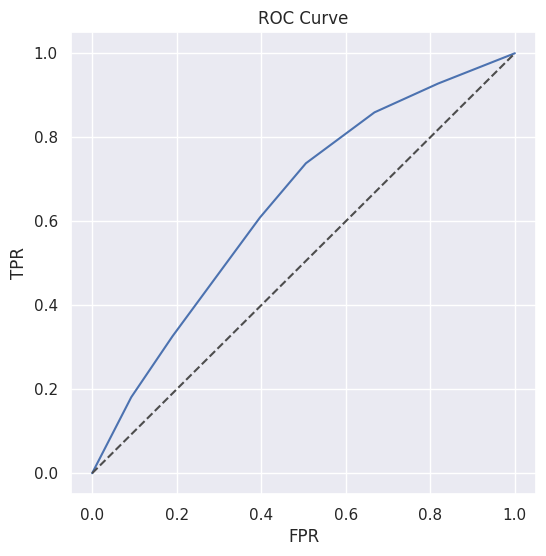

In [22]:
# ROC Curve 
y_scores = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_scores)

f, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr)
ax.plot((0,1), (0,1), ls="--", c=".3")
ax.set_title("ROC Curve")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

print('Area Under the ROC Curve:', roc_auc_score(y, y_scores))

## by allele frequency

In [23]:
custom_order = ['singleton','doubleton','<0.01%','0.01-0.1%',"0.1-1%","1-10%",">10%"]
ptvs_m['freq'] = pd.Categorical(ptvs_m['freq'], categories=custom_order, ordered=True)
ptvs_m.groupby(['freq','Panel'])['BETA'].describe()

/var/tmp/ipykernel_37954/1141874685.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ptvs_m.groupby(['freq','Panel'])['BETA'].describe()


count      mean       std       min       25%  \
freq      Panel                                                                
singleton Cardiometabolic     2325.0 -1.420486  1.467628 -4.483070 -2.559920   
          Neurology           2061.0 -1.188216  1.446688 -4.419300 -2.285830   
          Inflammation_II     2214.0 -1.116186  1.411755 -4.450870 -2.200568   
          Inflammation        1931.0 -1.142270  1.430005 -4.408000 -2.194355   
          Oncology            2020.0 -1.056188  1.394557 -4.404980 -2.079515   
          Cardiometabolic_II  2528.0 -0.695543  1.315358 -4.166460 -1.623978   
          Neurology_II        1965.0 -0.436928  1.189939 -3.922030 -1.235900   
          Oncology_II         2289.0 -0.372504  1.181196 -3.698650 -1.148050   
doubleton Cardiometabolic      534.0 -1.395461  1.326492 -3.811540 -2.460483   
          Neurology            420.0 -1.206847  1.176264 -3.870700 -1.950413   
          Inflammation_II      455.0 -1.091541  1.217290 -3.912420 -1.989815   
          Inflammation         461.0 -1.073392  1.229383 -3.919600 -1.937230   
          Oncology             465.0 -1.096361  1.218135 -3.603620 -1.999350   
          Cardiometabolic_II   533.0 -0.721572  1.083220 -3.369280 -1.517310   
          Neurology_II         452.0 -0.395596  0.911558 -2.787210 -0.971340   
          Oncology_II          450.0 -0.393009  0.925323 -2.833980 -0.958501   
<0.01%    Cardiometabolic      541.0 -1.262473  1.077777 -3.697230 -2.049690   
          Neurology            530.0 -1.131340  1.116717 -3.767180 -1.938320   
          Inflammation_II      512.0 -1.152927  1.077624 -3.653830 -2.052507   
          Inflammation         472.0 -1.032653  1.109805 -3.469770 -1.819220   
          Oncology             491.0 -0.869972  1.144780 -3.351820 -1.683785   
          Cardiometabolic_II   584.0 -0.769741  0.960230 -3.719770 -1.394732   
          Neurology_II         443.0 -0.414042  0.788843 -3.098330 -0.886014   
          Oncology_II          550.0 -0.352735  0.823107 -2.992910 -0.786525   
0.01-0.1% Cardiometabolic      161.0 -1.322627  0.972560 -3.136010 -2.035710   
          Neurology            151.0 -0.880028  1.115256 -3.007690 -1.699435   
          Inflammation_II      197.0 -1.127106  1.016236 -2.886100 -1.936130   
          Inflammation         176.0 -1.063511  1.001083 -2.902620 -1.805592   
          Oncology             168.0 -0.967356  0.967947 -2.957590 -1.688892   
          Cardiometabolic_II   174.0 -0.629448  0.789469 -2.943280 -1.154355   
          Neurology_II         134.0 -0.284203  0.626818 -2.326700 -0.432437   
          Oncology_II          192.0 -0.348313  0.689517 -2.834060 -0.720589   
0.1-1%    Cardiometabolic       24.0 -0.656534  1.158992 -2.705540 -1.679810   
          Neurology             31.0 -1.089874  0.786183 -2.413640 -1.643505   
          Inflammation_II       28.0 -0.844586  0.871475 -2.224220 -1.605142   
          Inflammation          29.0 -0.580417  1.010408 -2.499070 -1.279990   
          Oncology              31.0 -0.737102  0.814764 -2.477540 -1.312130   
          Cardiometabolic_II    19.0 -0.731275  0.774179 -2.336080 -1.025738   
          Neurology_II          24.0 -0.213075  0.487560 -1.429160 -0.445351   
          Oncology_II           27.0 -0.346932  0.461689 -1.767850 -0.628243   
1-10%     Cardiometabolic        4.0 -0.343662  0.588362 -1.212920 -0.450737   
          Neurology             12.0 -0.613464  0.689786 -1.582630 -1.080180   
          Inflammation_II        7.0 -0.651101  0.786139 -1.588100 -1.128367   
          Inflammation          11.0 -0.583542  0.664521 -1.872190 -0.983619   
          Oncology               5.0 -0.677584  0.637712 -1.497330 -0.954025   
          Cardiometabolic_II     6.0 -0.336068  0.704165 -1.621260 -0.293597   
          Neurology_II           1.0 -0.335734       NaN -0.335734 -0.335734   
          Oncology_II            9.0 -0.286751  0.414343 -0.928852 -0.550835   
>10%      Cardiometabolic      

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='BETA', ylabel='Panel'>

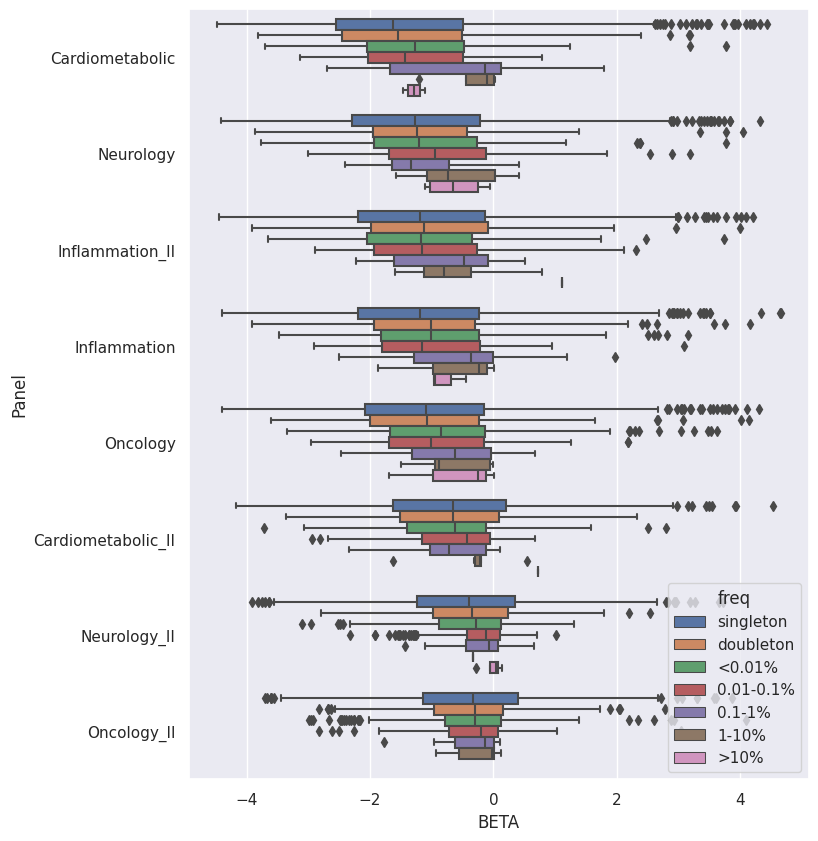

In [24]:
f, ax = plt.subplots(figsize=(8, 10))
sns.boxplot(data=ptvs_m, y='Panel', x='BETA', hue='freq')

In [25]:
# Performing two-way ANOVA to assess interaction term between frequency bucket and olink panel
model = ols('BETA ~ C(freq) + C(Panel) + C(freq):C(Panel)', 
            data=ptvs_m).fit() 
result = sm.stats.anova_lm(model, type=2) 
  
# Print the result 
print(result) 

                       df        sum_sq     mean_sq           F    PR(>F)
C(freq)               6.0     42.912619    7.152103    4.514161  0.000140
C(Panel)              7.0   3227.558727  461.079818  291.017681  0.000000
C(freq):C(Panel)     42.0     62.106855    1.478735    0.933326  0.594566
Residual          26810.0  42476.972182    1.584370         NaN       NaN


The interaction term is not significant - the relationship between Olink Panel and Beta is not dependent on allele frequency.

## by LOFTEE confidence

In [26]:
ptvs_m.groupby(['Panel','lof'], dropna=False)['BETA'].describe()

/var/tmp/ipykernel_37954/1175087903.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ptvs_m.groupby(['Panel','lof'], dropna=False)['BETA'].describe()


count      mean       std      min       25%  \
Panel              lof                                                  
Cardiometabolic    HC   3164.0 -1.425493  1.360012 -4.48307 -2.459410   
                   LC    227.0 -1.060088  1.419045 -3.72461 -2.084260   
                   NaN   200.0 -1.062765  1.465911 -4.32158 -2.257560   
Neurology          HC   2829.0 -1.216510  1.331878 -4.41930 -2.180370   
                   LC    204.0 -0.677588  1.384661 -3.67659 -1.626350   
                   NaN   176.0 -0.864568  1.318065 -3.52818 -1.817362   
Inflammation_II    HC   2924.0 -1.145749  1.307417 -4.23785 -2.157010   
                   LC    302.0 -0.883005  1.389606 -3.57485 -1.953262   
                   NaN   188.0 -1.013159  1.296569 -4.45087 -2.061265   
Inflammation       HC   2728.0 -1.133096  1.324667 -4.27724 -2.070460   
                   LC    187.0 -0.768349  1.331539 -4.40800 -1.759900   
                   NaN   168.0 -0.987964  1.356273 -4.13490 -1.910138   
Oncology           HC   2836.0 -1.051545  1.292974 -4.40498 -1.973990   
                   LC    173.0 -0.585664  1.486973 -4.31082 -1.665180   
                   NaN   174.0 -1.020998  1.321203 -3.98452 -2.062407   
Cardiometabolic_II HC   3375.0 -0.696694  1.218111 -4.16646 -1.527125   
                   LC    285.0 -0.776839  1.194049 -3.71977 -1.606390   
                   NaN   185.0 -0.780686  1.160248 -3.28264 -1.596320   
Neurology_II       HC   2740.0 -0.438527  1.070065 -3.92203 -1.146455   
                   LC    115.0 -0.138549  1.096691 -2.92287 -0.699232   
                   NaN   168.0 -0.279009  1.112835 -3.24881 -1.005557   
Oncology_II        HC   3109.0 -0.373529  1.080958 -3.69865 -1.033820   
                   LC    251.0 -0.352831  0.978401 -3.45017 -1.003950   
                   NaN   157.0 -0.334280  1.061375 -3.05308 -0.950555   

                             50%       75%      max  
Panel              lof                               
Cardiometabolic    HC  -1.580110 -0.528416  4.44317  
                   LC  -1.184080 -0.197745  4.10219  
                   NaN -1.057975  0.043997  4.22950  
Neurology          HC  -1.277780 -0.361413  4.32518  
                   LC  -0.650975  0.217520  4.04864  
                   NaN -0.767660  0.187363  2.16424  
Inflammation_II    HC  -1.207595 -0.199596  4.21225  
                   LC  -0.951164  0.026889  3.99834  
                   NaN -0.900294 -0.097971  2.62728  
Inflammation       HC  -1.172535 -0.263035  4.65809  
                   LC  -0.704968  0.302135  2.97704  
                   NaN -0.936446  0.006961  3.07898  
Oncology           HC  -1.050975 -0.178413  4.10683  
                   LC  -0.436108  0.159659  4.14319  
                   NaN -1.073230 -0.110992  4.30413  
Cardiometabolic_II HC  -0.617348  0.127059  4.53685  
                   LC  -0.794724 -0.047325  3.54767  
                   NaN -0.742089 -0.023253  2.59950  
Neurology_II       HC  -0.358765  0.269688  3.27735  
                   LC  -0.058783  0.419409  3.72969  
                   NaN -0.235305  0.336227  2.96942  
Oncology_II        HC  -0.306804  0.296282  4.09682  
                   LC  -0.288709  0.218091  2.56685  
                   NaN -0.262857  0.400539  1.87494

/var/tmp/ipykernel_37954/301005058.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ptvs_m['conf'].fillna('NA', inplace=True)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.

<Axes: xlabel='BETA', ylabel='Panel'>

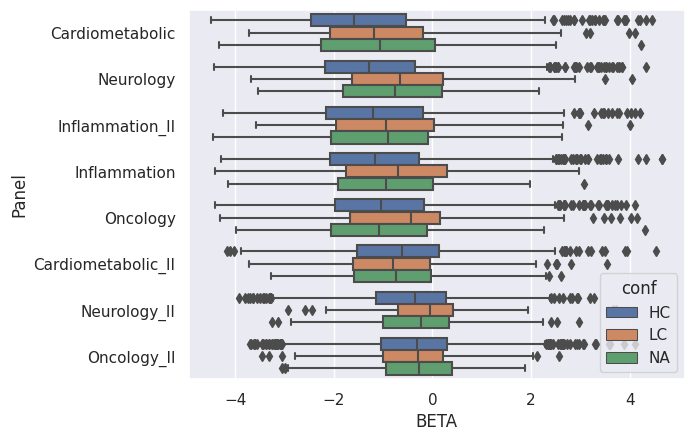

In [27]:
ptvs_m['conf'] = ptvs_m['lof']
ptvs_m['conf'].fillna('NA', inplace=True)
sns.boxplot(data=ptvs_m, y='Panel', x='BETA', hue='conf')

In [28]:
# Performing two-way ANOVA to assess interaction term between LOFTEE confidence and olink panel
model = ols('BETA ~ C(conf) + C(Panel) + C(conf):C(Panel)', 
            data=ptvs_m).fit() 
result = sm.stats.anova_lm(model, type=2) 
  
# Print the result 
print(result) 

                       df        sum_sq     mean_sq           F        PR(>F)
C(conf)               2.0    105.114674   52.557337   33.298791  3.601058e-15
C(Panel)              7.0   3240.766187  462.966598  293.322091  0.000000e+00
C(conf):C(Panel)     14.0     95.120026    6.794288    4.304662  1.077269e-07
Residual          26841.0  42364.645682    1.578356         NaN           NaN


The interaction term is significant - there is a slight interaction effect between LOFTEE confidence and Olink Panel on beta

In [29]:
# Combined field for LOFTEE confidence, Panel type
ptvs_m['conf_panel'] = ptvs_m['lof'].astype(str) + "," + ptvs_m['Panel'].astype(str)

In [30]:
# Dummy variables for confidence x olink panels
panels2 = pd.get_dummies(ptvs_m['conf_panel'])
panels2.drop('LC,Oncology_II', axis=1, inplace=True)

In [31]:
# logistic regression model of loss of function classification vs. LOFTEE confidence x olink panel
X = panels2
y = ptvs_m['loss_of_function']
model = LogisticRegression()
model.fit(X,y)

# coef significance
pvals=logit_pvalue(model, X)
df = pd.DataFrame(data=pvals, index=['intercept']+X.columns.tolist())
print(df.sort_values('Estimate'))
print("\n")

# confusion matrix / contingency table
pred = model.predict(X)
print(pd.crosstab(y, pred, margins=True))

# Evaluation metrics for default threshold 
print("\nEvaluation metrics with threshold 0.5:") 
assess_pred(y, pred)

                        Estimate  Std_Error     z_val         p_val
intercept              -0.822472   0.137065 -6.000617  1.965697e-09
LC,Neurology_II        -0.595371   0.272363 -2.185943  2.881978e-02
nan,Oncology_II        -0.301270   0.230631 -1.306288  1.914545e-01
nan,Neurology_II       -0.249634   0.223873 -1.115072  2.648195e-01
HC,Oncology_II         -0.240764   0.143082 -1.682697  9.243373e-02
HC,Neurology_II        -0.079066   0.143401 -0.551360  5.813870e-01
LC,Oncology             0.342903   0.207998  1.648589  9.923191e-02
HC,Cardiometabolic_II   0.357334   0.141553  2.524392  1.158987e-02
LC,Neurology            0.496951   0.197278  2.519040  1.176752e-02
nan,Cardiometabolic_II  0.536387   0.202123  2.653761  7.960012e-03
LC,Inflammation         0.539947   0.201511  2.679488  7.373493e-03
LC,Cardiometabolic_II   0.589487   0.181695  3.244375  1.177088e-03
nan,Neurology           0.647780   0.204176  3.172654  1.510525e-03
nan,Inflammation_II     0.725383   0.200284  3.6

intercept/reference = 'LC,Oncology_II'

Area Under the ROC Curve: 0.6474027233360717


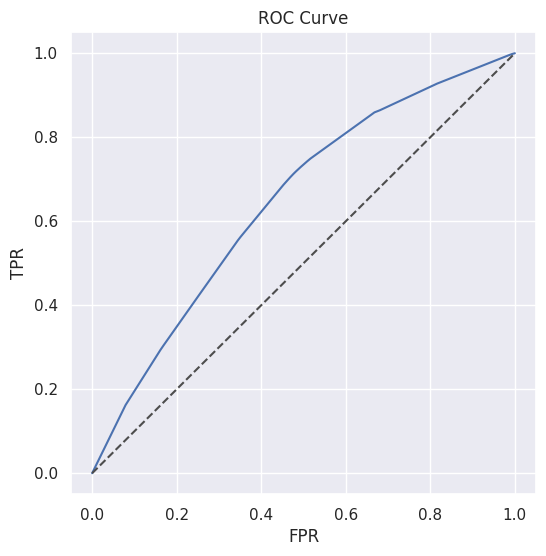

In [32]:
# ROC Curve 
y_scores = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_scores)

f, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr)
ax.plot((0,1), (0,1), ls="--", c=".3")
ax.set_title("ROC Curve")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

print('Area Under the ROC Curve:', roc_auc_score(y, y_scores))

Adding LOFTEE confidence only marginally improves AUC

# Olink assay Dilution Factor

In [33]:
# Variant count and beta breakdown by dilution factor
dil_grp = ptvs_m.groupby('Dilution_factor')
sorted_grp = dil_grp['BETA'].median().sort_values()
custom_order = sorted_grp.index.tolist()
ptvs_m['Dilution_factor'] = pd.Categorical(ptvs_m['Dilution_factor'].astype(str), categories=custom_order, ordered=True)
dil_grp = ptvs_m.groupby('Dilution_factor', observed=True)
dil_grp['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
Dilution_factor,,,,,,,,
1:100000,832.0,-1.690434,1.211171,-4.11062,-2.602368,-1.948390,-0.826847,2.14912
1:1000,1450.0,-1.695119,1.207957,-4.48307,-2.602395,-1.911040,-0.983351,3.99834
1:100,2703.0,-1.465888,1.363852,-4.38666,-2.491060,-1.619630,-0.596216,4.32518
1:10,4673.0,-1.250007,1.350796,-4.48250,-2.244060,-1.328670,-0.356386,4.65526
1:1,17207.0,-0.626518,1.199664,-4.41930,-1.436750,-0.554674,0.139488,4.65809


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='BETA', ylabel='Dilution_factor'>

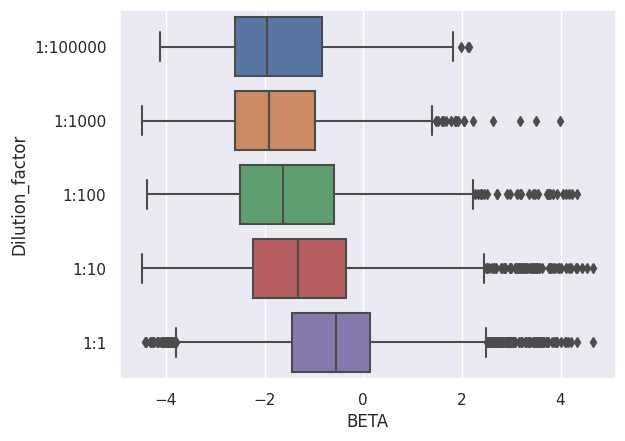

In [34]:
sns.boxplot(data=ptvs_m, y='Dilution_factor', x='BETA')

Text(0, 0.5, 'loss of function (%)')

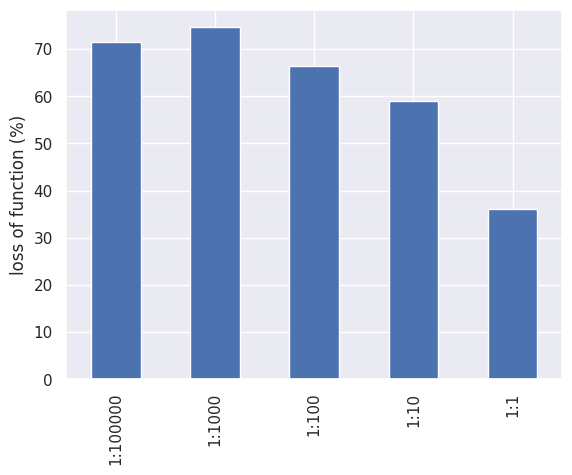

In [35]:
# plot percentage of each dilution factor that is loss-of-function
(dil_grp['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1].plot(kind='bar'))
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("loss of function (%)") ## Set Y-axis label

### Logistic Regression

In [36]:
# Dummy variables for dilution factors
dfs = pd.get_dummies(ptvs_m['Dilution_factor'])
dfs.drop('1:1', axis=1, inplace=True)

In [37]:
# logistic regression model of loss of function classification vs. dilution factor
X = dfs
y = ptvs_m['loss_of_function']
model = LogisticRegression()
model.fit(X,y)

# coef significance
pvals=logit_pvalue(model, X)
df = pd.DataFrame(data=pvals, index=['intercept']+X.columns.tolist())
print(df.sort_values('Estimate'))
print("\n")

# confusion matrix / contingency table
pred = model.predict(X)
print(pd.crosstab(y, pred, margins=True))

# Evaluation metrics for default threshold 
print("\nEvaluation metrics with threshold 0.5:") 
assess_pred(y, pred)

           Estimate  Std_Error      z_val  p_val
intercept -0.565565   0.015860 -35.658846    0.0
1:10       0.929631   0.033708  27.579131    0.0
1:100      1.242991   0.043678  28.458106    0.0
1:100000   1.476568   0.078279  18.862771    0.0
1:1000     1.637984   0.062308  26.288369    0.0


col_0                 0     1    All
loss_of_function                    
0                 10979  3429  14408
1                  6228  6229  12457
All               17207  9658  26865

Evaluation metrics with threshold 0.5:
Total: 26865
Correct predictions (accuracy): 17208 (64.1%)
TPR (recall/sensitivity)=TP/P: 50.0%
TNR (specificity)=TN/N: 76.2%
PPV (precision)=TP/(TP+FP): 64.5%
FDR (false discovery)=1-PPV: 35.5%
FPR (false positive rate)=FP/N=1-TNR: 23.8%
F1 score: 56.3%
OR (odds ratio)=(TP/FP)/(FN/TN): 3.2
Fisher exact test p-value: 0.0


intercept/reference = '1:1' dilution factor   
There is a significant correlation between the dilution factor and beta/LoF

Area Under the ROC Curve: 0.6392358536240849


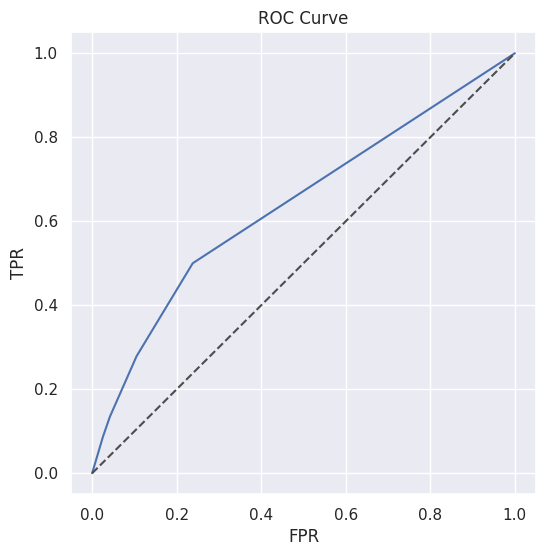

In [38]:
# ROC Curve 
y_scores = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_scores)

f, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr)
ax.plot((0,1), (0,1), ls="--", c=".3")
ax.set_title("ROC Curve")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

print('Area Under the ROC Curve:', roc_auc_score(y, y_scores))

AUC slightly less than for LR using Panel type

## Is there Panel Type x Dilution Factor interaction?

In [39]:
ptvs_m.groupby(['Panel','Dilution_factor'])['BETA'].describe()

/var/tmp/ipykernel_37954/70420806.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ptvs_m.groupby(['Panel','Dilution_factor'])['BETA'].describe()


count      mean       std      min  \
Panel              Dilution_factor                                        
Cardiometabolic    1:1000            856.0 -1.887780  1.184855 -4.48307   
                   1:100            1199.0 -1.519180  1.360852 -4.38666   
                   1:10              989.0 -1.182991  1.385142 -4.48250   
                   1:1               547.0 -0.650893  1.280594 -4.26497   
Neurology          1:100             925.0 -1.493003  1.394273 -4.31760   
                   1:10              564.0 -1.362928  1.367562 -4.30994   
                   1:1              1720.0 -0.919871  1.255013 -4.41930   
Inflammation_II    1:100000          832.0 -1.690434  1.211171 -4.11062   
                   1:1000            594.0 -1.417480  1.187658 -3.90756   
                   1:10              879.0 -1.163722  1.313114 -4.45087   
                   1:1              1109.0 -0.483296  1.190028 -3.92852   
Inflammation       1:10             1046.0 -1.297501  1.407519 -4.20289   
                   1:1              2037.0 -1.003219  1.276521 -4.40800   
Oncology           1:10              540.0 -1.346791  1.449821 -4.07333   
                   1:1              2643.0 -0.958717  1.269315 -4.40498   
Cardiometabolic_II 1:100             579.0 -1.312212  1.310959 -3.85903   
                   1:10              655.0 -1.214119  1.128347 -3.69833   
                   1:1              2611.0 -0.445097  1.120354 -4.16646   
Neurology_II       1:1              3023.0 -0.418250  1.075195 -3.92203   
Oncology_II        1:1              3517.0 -0.370299  1.072854 -3.69865   

                                         25%       50%       75%      max  
Panel              Dilution_factor                                         
Cardiometabolic    1:1000          -2.772613 -2.127115 -1.274393  3.50463  
                   1:100           -2.587745 -1.665030 -0.639328  4.22950  
                   1:10            -2.157230 -1.192660 -0.271748  4.44317  
                   1:1             -1.597620 -0.645081  0.209053  4.20686  
Neurology          1:100           -2.489930 -1.655510 -0.612384  4.32518  
                   1:10            -2.407230 -1.512970 -0.459627  3.84145  
                   1:1             -1.757380 -0.945171 -0.112840  3.65750  
Inflammation_II    1:100000        -2.602368 -1.948390 -0.826847  2.14912  
                   1:1000          -2.297355 -1.551300 -0.720152  3.99834  
                   1:10            -2.148485 -1.169220 -0.277013  4.21225  
                   1:1             -1.351390 -0.461304  0.234318  4.10397  
Inflammation       1:10            -2.384028 -1.376465 -0.298736  4.65526  
                   1:1             -1.863740 -1.043130 -0.202366  4.65809  
Oncology           1:10            -2.409430 -1.642155 -0.402681  4.30413  
                   1:1             -1.859650 -0.942888 -0.121402  4.14319  
Cardiometabolic_II 1:100           -2.297775 -1.447280 -0.442885  3.93641  
                   1:10            -1.989070 -1.300400 -0.476305  4.53685  
                   1:1             -1.123495 -0.361038  0.257279  3.91339  
Neurology_II       1:1             -1.124580 -0.337482  0.279019  3.72969  
Oncology_II        1:1             -1.024060 -0.303204  0.293165  4.09682

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='BETA', ylabel='Panel'>

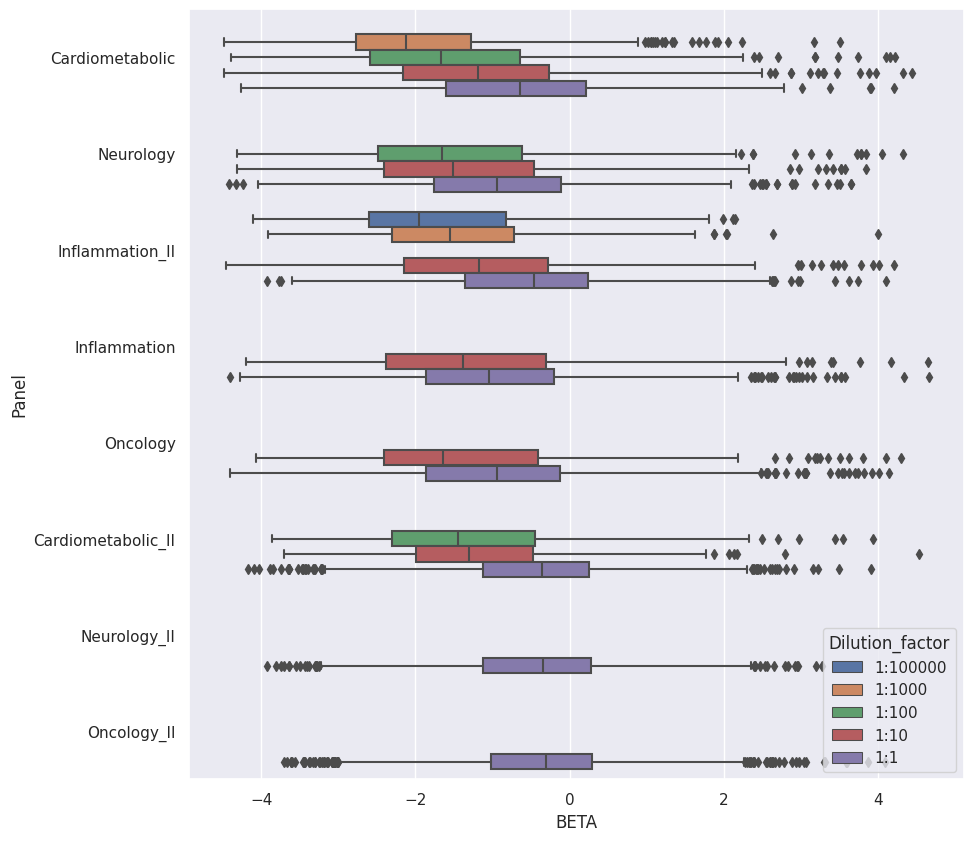

In [40]:
f, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(data=ptvs_m, y='Panel', x='BETA', hue='Dilution_factor')

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='BETA', ylabel='Dilution_factor'>

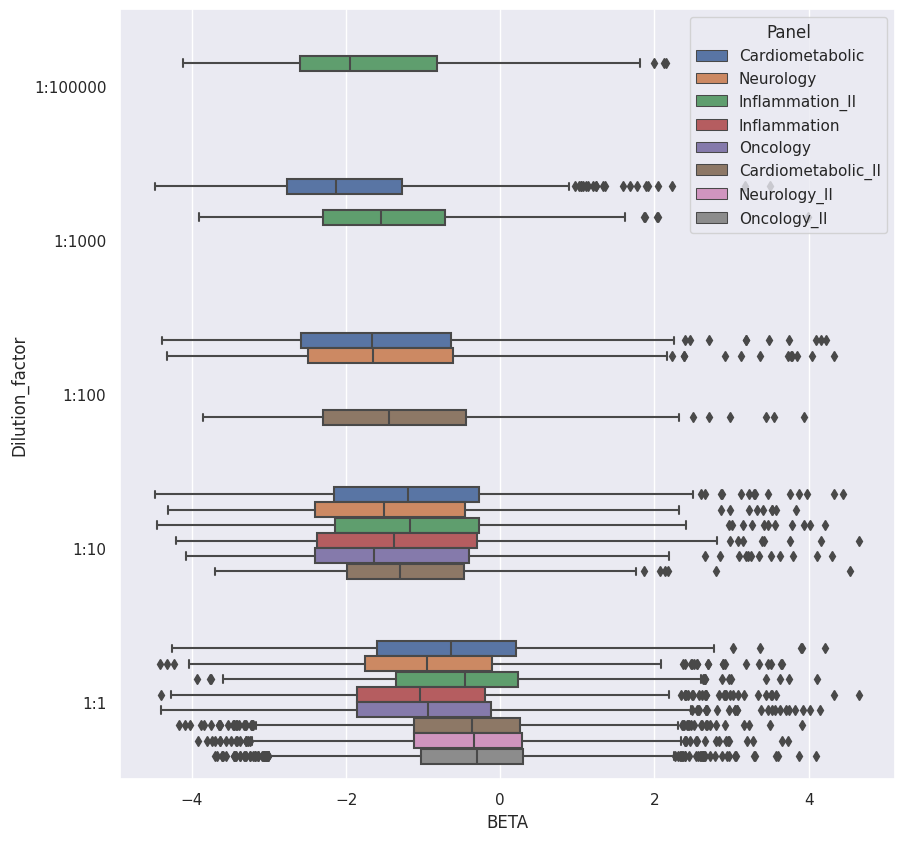

In [41]:
f, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(data=ptvs_m, y='Dilution_factor', x='BETA', hue='Panel')

In [42]:
# Performing two-way ANOVA to assess interaction term between dilution factor and olink panel
model = ols('BETA ~ C(Dilution_factor) + C(Panel) + C(Dilution_factor):C(Panel)', 
            data=ptvs_m).fit() 
result = sm.stats.anova_lm(model, type=2) 
  
# Print the result 
print(result) 

                                  df        sum_sq      mean_sq           F  \
C(Dilution_factor)               4.0   4158.814086  1039.703522  692.142022   
C(Panel)                         7.0   1179.129215   168.447031  112.137033   
C(Dilution_factor):C(Panel)     28.0    190.344047     6.798002    4.525504   
Residual                     26845.0  40325.309156     1.502153         NaN   

                                    PR(>F)  
C(Dilution_factor)            0.000000e+00  
C(Panel)                     8.459696e-163  
C(Dilution_factor):C(Panel)   1.787035e-14  
Residual                               NaN  


The interaction term is significant - there is a slight interaction effect between dilution factor and Olink Panel on beta

In [43]:
# Combined field for dilution factor, panel type
ptvs_m['df_panel'] = ptvs_m['Dilution_factor'].astype(str) + "," + ptvs_m['Panel'].astype(str)

In [44]:
# Dummy variables for combined dilution factors x olink panels
dfs2 = pd.get_dummies(ptvs_m['df_panel'])
dfs2.drop('1:1,Oncology_II', axis=1, inplace=True)

In [45]:
# logistic regression model of loss of function classification vs. dilution factor x olink panel
X = dfs2
y = ptvs_m['loss_of_function']
model = LogisticRegression()
model.fit(X,y)

# coef significance
pvals=logit_pvalue(model, X)
df = pd.DataFrame(data=pvals, index=['intercept']+X.columns.tolist())
print(df.sort_values('Estimate'))
print("\n")

# confusion matrix / contingency table
pred = model.predict(X)
print(pd.crosstab(y, pred, margins=True))

# Evaluation metrics for default threshold 
print("\nEvaluation metrics with threshold 0.5:") 
assess_pred(y, pred)

                          Estimate  Std_Error      z_val         p_val
intercept                -1.033696   0.038330 -26.968346  0.000000e+00
1:1,Cardiometabolic_II    0.100890   0.057959   1.740701  8.173607e-02
1:1,Neurology_II          0.102586   0.055682   1.842345  6.542466e-02
1:1,Inflammation_II       0.295945   0.074763   3.958442  7.544029e-05
1:1,Cardiometabolic       0.636585   0.095257   6.682811  2.344014e-11
1:1,Neurology             0.952342   0.061633  15.451844  0.000000e+00
1:1,Oncology              0.969351   0.054628  17.744689  0.000000e+00
1:1,Inflammation          1.095682   0.058607  18.695511  0.000000e+00
1:10,Inflammation_II      1.287104   0.078059  16.488786  0.000000e+00
1:10,Cardiometabolic      1.291413   0.074707  17.286267  0.000000e+00
1:10,Inflammation         1.400102   0.073641  19.012411  0.000000e+00
1:10,Cardiometabolic_II   1.449199   0.088563  16.363438  0.000000e+00
1:10,Oncology             1.497035   0.096340  15.539140  0.000000e+00
1:10,N

Area Under the ROC Curve: 0.6865352236457434


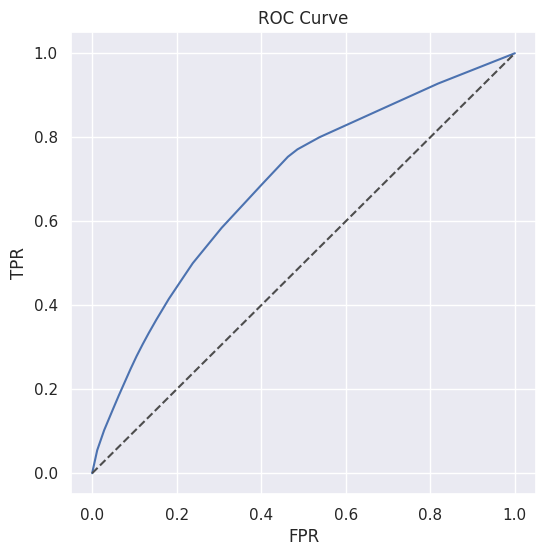

In [46]:
# ROC Curve 
y_scores = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_scores)

f, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr)
ax.plot((0,1), (0,1), ls="--", c=".3")
ax.set_title("ROC Curve")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

print('Area Under the ROC Curve:', roc_auc_score(y, y_scores))

Combining Dilution Factor and Panel Type results in the best AUC so far

# Panel 'Version'

In [47]:
ptvs_m.groupby(['Version', 'Panel'])['BETA'].describe()

/var/tmp/ipykernel_37954/1960125986.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ptvs_m.groupby(['Version', 'Panel'])['BETA'].describe()


count      mean       std      min       25%  \
Version Panel                                                               
expand  Inflammation_II     3414.0 -1.115206  1.316238 -4.45087 -2.130883   
        Cardiometabolic_II  3845.0 -0.706676  1.213616 -4.16646 -1.542750   
        Neurology_II        3023.0 -0.418250  1.075195 -3.92203 -1.124580   
        Oncology_II         3517.0 -0.370299  1.072854 -3.69865 -1.024060   
explore Cardiometabolic     3591.0 -1.382192  1.374560 -4.48307 -2.425625   
        Neurology           3209.0 -1.162947  1.342484 -4.41930 -2.139750   
        Inflammation        3083.0 -1.103063  1.329516 -4.40800 -2.049845   
        Oncology            3183.0 -1.024554  1.309586 -4.40498 -1.966515   

                                 50%       75%      max  
Version Panel                                            
expand  Inflammation_II    -1.165385 -0.172500  4.21225  
        Cardiometabolic_II -0.627740  0.107081  4.53685  
        Neurology_II       -0.337482  0.279019  3.72969  
        Oncology_II        -0.303204  0.293165  4.09682  
explore Cardiometabolic    -1.532250 -0.476969  4.44317  
        Neurology          -1.223500 -0.259808  4.32518  
        Inflammation       -1.148750 -0.226528  4.65809  
        Oncology           -1.024980 -0.156585  4.30413

<Axes: xlabel='BETA', ylabel='Version'>

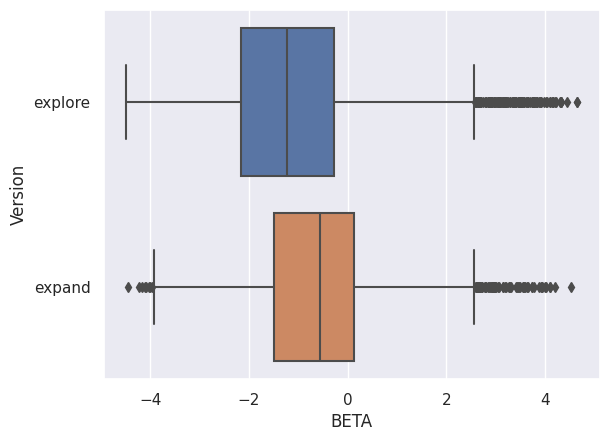

In [48]:
sns.boxplot(data=ptvs_m, y='Version', x='BETA')

In [49]:
ver_grp = ptvs_m.groupby('Version')
x = (ver_grp['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1])
x

Version
expand     37.046163
explore    56.214603
Name: proportion, dtype: float64

/var/tmp/ipykernel_37954/2902092120.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, x[i], int(np.round(x[i],0)), ha = 'center')


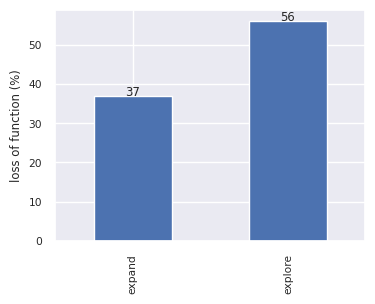

In [50]:
sns.set(font_scale=0.7)
f, ax = plt.subplots(figsize=(4, 3))
x.plot(kind='bar')
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("loss of function (%)") ## Set Y-axis label
for i in range(len(x)):
    plt.text(i, x[i], int(np.round(x[i],0)), ha = 'center')

In [51]:
# Dummy variables for panel version
ver = pd.get_dummies(ptvs_m['Version'])
ver.drop('expand', axis=1, inplace=True)

In [52]:
# logistic regression model of loss of function classification vs. panel version
X = ver
y = ptvs_m['loss_of_function']
model = LogisticRegression()
model.fit(X,y)

# coef significance
pvals=logit_pvalue(model, X)
df = pd.DataFrame(data=pvals, index=['intercept']+X.columns.tolist())
print(df.sort_values('Estimate'))
print("\n")

# confusion matrix / contingency table
pred = model.predict(X)
print(pd.crosstab(y, pred, margins=True))

# Evaluation metrics for default threshold 
print("\nEvaluation metrics with threshold 0.5:") 
assess_pred(y, pred)

           Estimate  Std_Error      z_val  p_val
intercept -0.529775   0.017627 -30.055497    0.0
explore    0.779444   0.024932  31.262158    0.0


col_0                 0      1    All
loss_of_function                     
0                  8687   5721  14408
1                  5112   7345  12457
All               13799  13066  26865

Evaluation metrics with threshold 0.5:
Total: 26865
Correct predictions (accuracy): 16032 (59.7%)
TPR (recall/sensitivity)=TP/P: 59.0%
TNR (specificity)=TN/N: 60.3%
PPV (precision)=TP/(TP+FP): 56.2%
FDR (false discovery)=1-PPV: 43.8%
FPR (false positive rate)=FP/N=1-TNR: 39.7%
F1 score: 57.6%
OR (odds ratio)=(TP/FP)/(FN/TN): 2.18
Fisher exact test p-value: 4.8608779952747336e-219


Area Under the ROC Curve: 0.5962786248994153


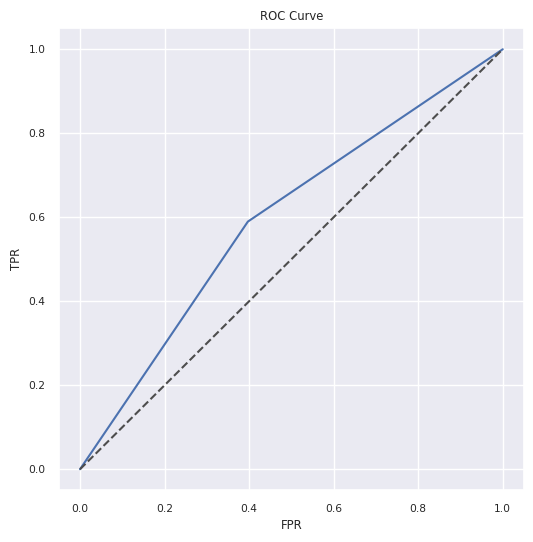

In [53]:
# ROC Curve 
y_scores = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_scores)

f, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr)
ax.plot((0,1), (0,1), ls="--", c=".3")
ax.set_title("ROC Curve")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

print('Area Under the ROC Curve:', roc_auc_score(y, y_scores))

Version not as strong of a predictor as individual panel types  
(For panel types: AUC = 0.642)

In [54]:
# Combined field for version, dilution factor
ptvs_m['ver_df'] = ptvs_m['Version'].astype(str) + "," + ptvs_m['Dilution_factor'].astype(str)

In [55]:
# Dummy variables for combined version x dilution factors
ver2 = pd.get_dummies(ptvs_m['ver_df'])
ver2.drop('expand,1:1', axis=1, inplace=True)

In [56]:
# logistic regression model of loss of function classification vs. dilution factor x olink panel
X = ver2
y = ptvs_m['loss_of_function']
model = LogisticRegression()
model.fit(X,y)

# coef significance
pvals=logit_pvalue(model, X)
df = pd.DataFrame(data=pvals, index=['intercept']+X.columns.tolist())
print(df.sort_values('Estimate'))
print("\n")

# confusion matrix / contingency table
pred = model.predict(X)
print(pd.crosstab(y, pred, margins=True))

# Evaluation metrics for default threshold 
print("\nEvaluation metrics with threshold 0.5:") 
assess_pred(y, pred)

                 Estimate  Std_Error      z_val  p_val
intercept       -0.948597   0.022008 -43.102745    0.0
explore,1:1      0.892627   0.032567  27.409282    0.0
expand,1:10      1.274753   0.056231  22.670129    0.0
explore,1:10     1.327034   0.042483  31.236819    0.0
expand,1:100     1.556853   0.089731  17.350126    0.0
explore,1:100    1.644316   0.051037  32.217911    0.0
expand,1:1000    1.655563   0.089974  18.400371    0.0
expand,1:100000  1.855302   0.079685  23.282894    0.0
explore,1:1000   2.307238   0.087558  26.350833    0.0


col_0                 0     1    All
loss_of_function                    
0                 10979  3429  14408
1                  6228  6229  12457
All               17207  9658  26865

Evaluation metrics with threshold 0.5:
Total: 26865
Correct predictions (accuracy): 17208 (64.1%)
TPR (recall/sensitivity)=TP/P: 50.0%
TNR (specificity)=TN/N: 76.2%
PPV (precision)=TP/(TP+FP): 64.5%
FDR (false discovery)=1-PPV: 35.5%
FPR (false positive rate)=FP

In [57]:
# logistic regression model of loss of function classification vs. dilution factor x olink panel
X = ver2
y = ptvs_m['loss_of_function']
model = LogisticRegression()
model.fit(X,y)

# coef significance
pvals=logit_pvalue(model, X)
df = pd.DataFrame(data=pvals, index=['intercept']+X.columns.tolist())
print(df.sort_values('Estimate'))
#print("\n")
print("intercept = expand,1:1")

                 Estimate  Std_Error      z_val  p_val
intercept       -0.948597   0.022008 -43.102745    0.0
explore,1:1      0.892627   0.032567  27.409282    0.0
expand,1:10      1.274753   0.056231  22.670129    0.0
explore,1:10     1.327034   0.042483  31.236819    0.0
expand,1:100     1.556853   0.089731  17.350126    0.0
explore,1:100    1.644316   0.051037  32.217911    0.0
expand,1:1000    1.655563   0.089974  18.400371    0.0
expand,1:100000  1.855302   0.079685  23.282894    0.0
explore,1:1000   2.307238   0.087558  26.350833    0.0
intercept = expand,1:1


In [58]:
# model predictions
ptvs_m['predictions'] = model.predict(X)

ver_df = ptvs_m.groupby('ver_df')
x = (ver_df['predictions']
 .value_counts(normalize=True)
 .mul(100)
 [:,1])
x

ver_df
expand,1:10        100.0
expand,1:100       100.0
expand,1:1000      100.0
expand,1:100000    100.0
explore,1:10       100.0
explore,1:100      100.0
explore,1:1000     100.0
Name: proportion, dtype: float64

In [59]:
ver_df['predictions'].describe()

,count,mean,std,min,25%,50%,75%,max
ver_df,,,,,,,,
"expand,1:1",10260.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"expand,1:10",1534.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
"expand,1:100",579.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
"expand,1:1000",594.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
"expand,1:100000",832.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
"explore,1:1",6947.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"explore,1:10",3139.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
"explore,1:100",2124.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
"explore,1:1000",856.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [60]:
ver_df['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
ver_df,,,,,,,,
"expand,1:1",10260.0,-0.415676,1.099420,-4.16646,-1.104618,-0.341785,0.272243,4.10397
"expand,1:10",1534.0,-1.185241,1.237465,-4.45087,-2.068420,-1.246210,-0.400207,4.53685
"expand,1:100",579.0,-1.312212,1.310959,-3.85903,-2.297775,-1.447280,-0.442885,3.93641
"expand,1:1000",594.0,-1.417480,1.187658,-3.90756,-2.297355,-1.551300,-0.720152,3.99834
"expand,1:100000",832.0,-1.690434,1.211171,-4.11062,-2.602368,-1.948390,-0.826847,2.14912
"explore,1:1",6947.0,-0.937910,1.271673,-4.41930,-1.812975,-0.955774,-0.119691,4.65809
"explore,1:10",3139.0,-1.281658,1.401955,-4.48250,-2.335750,-1.391080,-0.338478,4.65526
"explore,1:100",2124.0,-1.507780,1.375242,-4.38666,-2.554125,-1.658090,-0.618782,4.32518
"explore,1:1000",856.0,-1.887780,1.184855,-4.48307,-2.772613,-2.127115,-1.274393,3.50463


In [61]:
x = (ver_df['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1]
 .sort_values())
x

ver_df
expand,1:1         27.777778
explore,1:1        48.625306
expand,1:10        58.148631
explore,1:10       59.445683
expand,1:100       64.939551
explore,1:100      66.760829
expand,1:1000      67.171717
expand,1:100000    71.514423
explore,1:1000     79.789720
Name: proportion, dtype: float64

/var/tmp/ipykernel_37954/2902092120.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, x[i], int(np.round(x[i],0)), ha = 'center')


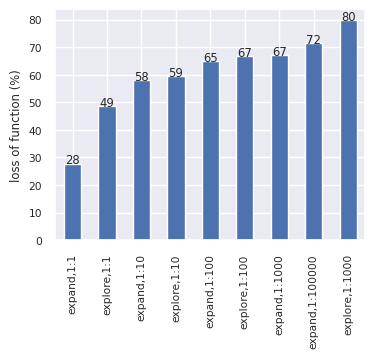

In [62]:
sns.set(font_scale=0.7)
f, ax = plt.subplots(figsize=(4, 3))
x.plot(kind='bar')
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("loss of function (%)") ## Set Y-axis label
for i in range(len(x)):
    plt.text(i, x[i], int(np.round(x[i],0)), ha = 'center')

intercept/reference = 'expand,1:01'

In [63]:
indices = ptvs_m.loc[ptvs_m['ver_df']=='expand,1:1',:].index.tolist()
print(pd.crosstab(y[indices], pred[indices], margins=True))
print(sum(pred[indices])/len(pred[indices])*100)

col_0                 0    All
loss_of_function              
0                  7410   7410
1                  2850   2850
All               10260  10260
0.0


In [64]:
indices = ptvs_m.loc[ptvs_m['ver_df']=='explore,1:1',:].index.tolist()
print(pd.crosstab(y[indices], pred[indices], margins=True))
print(sum(pred[indices])/len(pred[indices])*100)

col_0                0   All
loss_of_function            
0                 3569  3569
1                 3378  3378
All               6947  6947
0.0


In [65]:
indices2 = ptvs_m.loc[ptvs_m['ver_df']!='expand,1:1',:].index.tolist()
print(pd.crosstab(y[indices2], pred[indices2], margins=True))
print(sum(pred[indices2])/len(pred[indices2])*100)

col_0                0     1    All
loss_of_function                   
0                 3569  3429   6998
1                 3378  6229   9607
All               6947  9658  16605
58.16320385426077


Area Under the ROC Curve: 0.6811659510158589


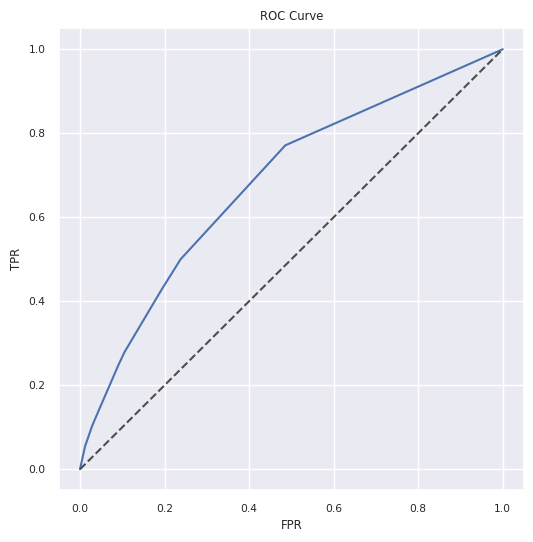

In [66]:
# ROC Curve 
y_scores = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_scores)

f, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr)
ax.plot((0,1), (0,1), ls="--", c=".3")
ax.set_title("ROC Curve")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

print('Area Under the ROC Curve:', roc_auc_score(y, y_scores))

AUC slightly less than combined dilution factor and panel type (AUC: 0.687)

# Breakdown by gene

In [67]:
# group by gene and calculate mean beta by gene
gene_grp = ptvs_m.groupby('symbol')
gene_beta = gene_grp['BETA'].mean()
gene_beta

symbol
A1BG      -2.765575
AAMDC     -1.230230
AARSD1    -2.079627
ABCA2     -0.685092
ABHD14B   -1.633767
             ...   
YJU2      -0.331644
YOD1      -1.317060
YTHDF3     0.717840
ZBTB16    -0.089578
ZBTB17    -0.855551
Name: BETA, Length: 2678, dtype: float64

In [68]:
# merge mean beta by gene with olink annotations
gene_m = pd.merge(gene_beta, annot, how='inner', left_index=True, right_on='symbol')

In [69]:
gene_m['loss_of_function'] = [1 if x<=-1 else 0 for x in gene_m['BETA']]

In [70]:
# Gene count and mean beta breakdown by dilution factor
dil_grp2 = gene_m.groupby('Dilution_factor')
sorted_grp = dil_grp2['BETA'].median().sort_values()
custom_order = sorted_grp.index.tolist()
gene_m['Dilution_factor'] = pd.Categorical(gene_m['Dilution_factor'].astype(str), categories=custom_order, ordered=True)
dil_grp2 = gene_m.groupby('Dilution_factor', observed=True)
dil_grp2['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
Dilution_factor,,,,,,,,
1:100000,69.0,-1.772377,0.815088,-3.49898,-2.295810,-1.825514,-1.227366,0.124111
1:1000,118.0,-1.691778,0.857772,-4.48307,-2.263189,-1.812023,-1.137917,0.874340
1:100,249.0,-1.468962,0.861484,-3.64062,-2.099153,-1.571008,-0.926172,1.386150
1:10,496.0,-1.246049,0.875143,-3.89154,-1.826009,-1.238819,-0.635030,2.508420
1:1,1761.0,-0.611584,0.808266,-3.32721,-1.113495,-0.499291,-0.064635,3.448040


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='BETA', ylabel='Dilution_factor'>

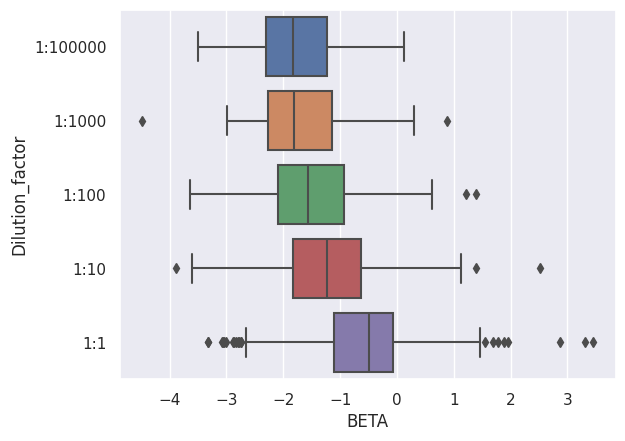

In [71]:
sns.set()
sns.boxplot(data=gene_m, y='Dilution_factor', x='BETA')

In [72]:
custom_order = sorted_grp.index.tolist()[::-1]
gene_m['Dilution_factor'] = pd.Categorical(gene_m['Dilution_factor'].astype(str), categories=custom_order, ordered=True)
dil_grp3 = gene_m.groupby('Dilution_factor', observed=True)
dil_grp3['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
Dilution_factor,,,,,,,,
1:1,1761.0,-0.611584,0.808266,-3.32721,-1.113495,-0.499291,-0.064635,3.448040
1:10,496.0,-1.246049,0.875143,-3.89154,-1.826009,-1.238819,-0.635030,2.508420
1:100,249.0,-1.468962,0.861484,-3.64062,-2.099153,-1.571008,-0.926172,1.386150
1:1000,118.0,-1.691778,0.857772,-4.48307,-2.263189,-1.812023,-1.137917,0.874340
1:100000,69.0,-1.772377,0.815088,-3.49898,-2.295810,-1.825514,-1.227366,0.124111


/var/tmp/ipykernel_37954/1210220354.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, x[i], int(np.round(x[i],0)), ha = 'center')


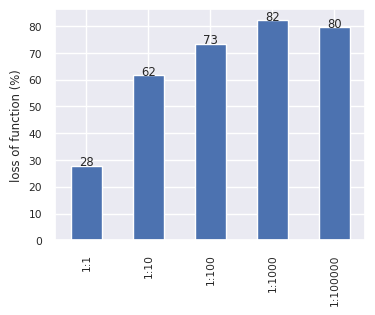

In [73]:
# plot percentage of each dilution factor that is loss-of-function
x = (dil_grp3['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1])

sns.set(font_scale=0.7)
f, ax = plt.subplots(figsize=(4, 3))
x.plot(kind='bar')
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("loss of function (%)") ## Set Y-axis label
for i in range(len(x)):
    plt.text(i, x[i], int(np.round(x[i],0)), ha = 'center')

In [74]:
obs = pd.crosstab(gene_m['loss_of_function'], gene_m['Dilution_factor'], normalize='columns')
print("By gene: loss of function fraction for each dilution factor\n")
print(obs)
exp = pd.crosstab(ptvs_m['loss_of_function'], ptvs_m['Dilution_factor'], normalize='columns')
print("\n\nBy variant: loss of function fraction for each dilution factor\n")
print(exp)

stat, pvals = stats.chisquare(obs, exp)
print("\nChi-squared test p-values comparing frequencies for each group (null hypothesis = the frequencies are the same between the two tables)")
print(pvals)

By gene: loss of function fraction for each dilution factor

Dilution_factor        1:1      1:10    1:100    1:1000  1:100000
loss_of_function                                                 
0                 0.721181  0.383065  0.26506  0.177966  0.202899
1                 0.278819  0.616935  0.73494  0.822034  0.797101


By variant: loss of function fraction for each dilution factor

Dilution_factor   1:100000    1:1000     1:100      1:10       1:1
loss_of_function                                                  
0                 0.284856  0.253793  0.336293  0.409801  0.638054
1                 0.715144  0.746207  0.663707  0.590199  0.361946

Chi-squared test p-values comparing frequencies for each group (null hypothesis = the frequencies are the same between the two tables)
[0.33368354 0.76642656 0.88015229 0.63735243 0.36519425]


## by panel type

In [75]:
# Gene count and beta breakdown for each panel
panel_grp2 = gene_m.groupby('Panel')
sorted_grp = panel_grp2['BETA'].median().sort_values()
custom_order = sorted_grp.index.tolist()
gene_m['Panel'] = pd.Categorical(gene_m['Panel'], categories=custom_order, ordered=True)
panel_grp2 = gene_m.groupby('Panel', observed=True)
panel_grp2['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
Panel,,,,,,,,
Cardiometabolic,354.0,-1.337655,0.963034,-4.483070,-2.047033,-1.373095,-0.756225,2.508420
Neurology,346.0,-1.104521,0.875988,-3.640620,-1.694391,-1.126882,-0.488373,1.350960
Inflammation,345.0,-1.034207,0.856463,-3.040204,-1.621445,-0.995216,-0.467190,1.888040
Oncology,341.0,-0.991429,0.891069,-3.481480,-1.687005,-0.942949,-0.396552,1.954940
Inflammation_II,336.0,-1.025263,1.030387,-3.498980,-1.827558,-0.916769,-0.254930,3.448040
Cardiometabolic_II,332.0,-0.761120,0.826036,-3.293180,-1.346846,-0.692955,-0.114333,1.778284
Oncology_II,322.0,-0.362357,0.696936,-2.635917,-0.747083,-0.290399,0.020797,3.308450
Neurology_II,317.0,-0.373199,0.619496,-2.472000,-0.708284,-0.279221,0.040654,1.084174


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='BETA', ylabel='Panel'>

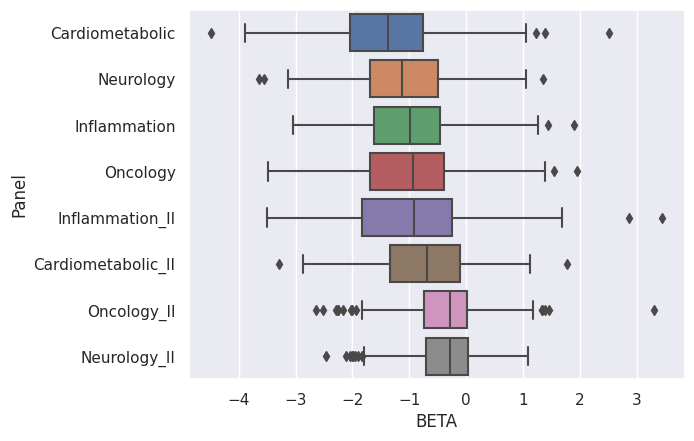

In [76]:
sns.set()
sns.boxplot(data=gene_m, y='Panel', x='BETA')

In [77]:
gene_m.groupby(['Panel','Dilution_factor'])['BETA'].describe()

/var/tmp/ipykernel_37954/1049743501.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gene_m.groupby(['Panel','Dilution_factor'])['BETA'].describe()


count      mean       std       min  \
Panel              Dilution_factor                                        
Cardiometabolic    1:1               66.0 -0.546486  0.813098 -2.072782   
                   1:10             108.0 -1.317882  0.921080 -3.891540   
                   1:100            107.0 -1.514808  0.893891 -2.982515   
                   1:1000            73.0 -1.822549  0.808451 -4.483070   
Neurology          1:1              197.0 -0.871620  0.837749 -2.878417   
                   1:10              59.0 -1.269710  0.809126 -3.057150   
                   1:100             90.0 -1.506023  0.837358 -3.640620   
Inflammation       1:1              232.0 -0.929878  0.844961 -3.040204   
                   1:10             113.0 -1.248405  0.843568 -3.000895   
Oncology           1:1              282.0 -0.923329  0.860654 -3.327210   
                   1:10              59.0 -1.316923  0.967214 -3.481480   
Inflammation_II    1:1              134.0 -0.354973  0.868918 -3.326060   
                   1:10              88.0 -1.227776  0.848947 -3.145197   
                   1:1000            45.0 -1.479638  0.901428 -2.965304   
                   1:100000          69.0 -1.772377  0.815088 -3.498980   
Cardiometabolic_II 1:1              211.0 -0.523996  0.709203 -2.862381   
                   1:10              69.0 -1.072228  0.863442 -3.293180   
                   1:100             52.0 -1.310482  0.831931 -2.826368   
Oncology_II        1:1              322.0 -0.362357  0.696936 -2.635917   
Neurology_II       1:1              317.0 -0.373199  0.619496 -2.472000   

                                         25%       50%       75%       max  
Panel              Dilution_factor                                          
Cardiometabolic    1:1             -1.170450 -0.541228  0.053411  1.049060  
                   1:10            -1.795667 -1.244096 -0.802391  2.508420  
                   1:100           -2.178872 -1.658882 -1.072801  1.386150  
                   1:1000          -2.266253 -1.927922 -1.406533  0.291526  
Neurology          1:1             -1.522049 -0.888987 -0.292106  1.350960  
                   1:10            -1.820466 -1.346138 -0.720136  0.087388  
                   1:100           -2.082288 -1.577376 -0.881817  0.443904  
Inflammation       1:1             -1.463088 -0.908337 -0.360826  1.888040  
                   1:10            -1.821820 -1.217463 -0.610682  1.125065  
Oncology           1:1             -1.581550 -0.852543 -0.350693  1.954940  
                   1:10            -2.011432 -1.477514 -0.615434  1.386843  
Inflammation_II    1:1             -0.726824 -0.259334  0.062282  3.448040  
                   1:10            -1.881362 -1.242359 -0.574470  1.111915  
                   1:1000          -2.222962 -1.623421 -0.796814  0.874340  
                   1:100000        -2.295810 -1.825514 -1.227366  0.124111  
Cardiometabolic_II 1:1             -0.936369 -0.407131 -0.022664  1.778284  
                   1:10            -1.639308 -1.110426 -0.690135  1.114730  
                   1:100           -1.846358 -1.496027 -0.814510  0.618561  
Oncology_II        1:1             -0.747083 -0.290399  0.020797  3.308450  
Neurology_II       1:1             -0.708284 -0.279221  0.040654  1.084174

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='BETA', ylabel='Dilution_factor'>

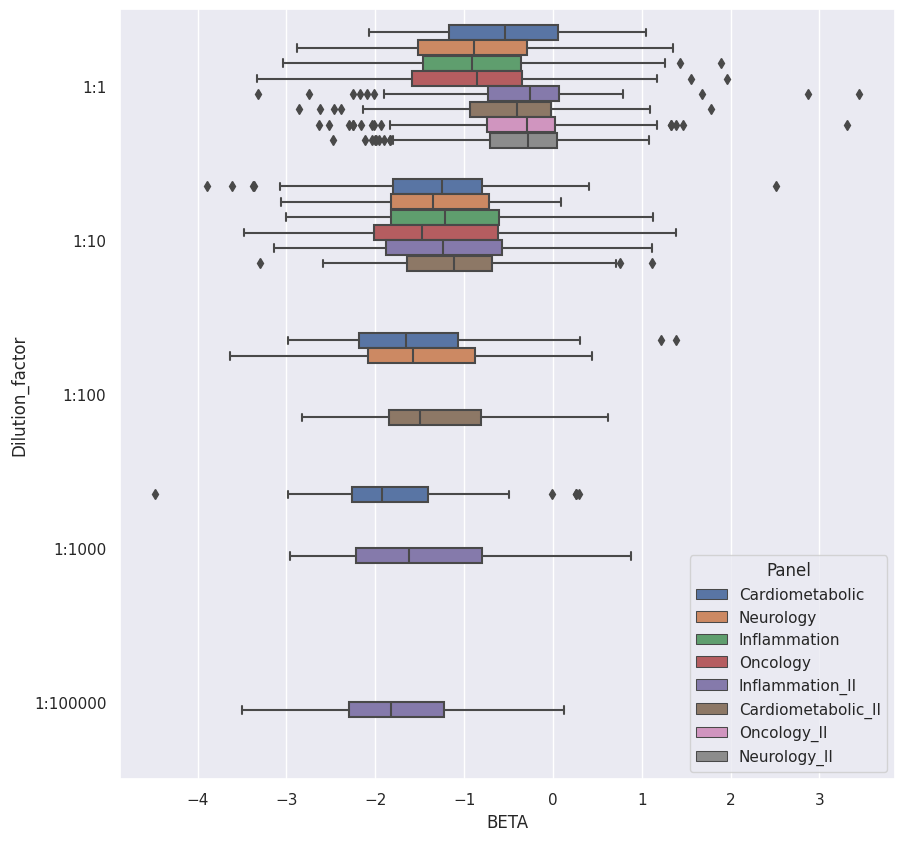

In [78]:
sns.set()
f, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(data=gene_m, y='Dilution_factor', x='BETA', hue='Panel')

## panel version

In [79]:
# Gene count and mean beta breakdown by version
ver_grp2 = gene_m.groupby('Version')
#sorted_grp = ver_grp2['BETA'].median().sort_values()
#custom_order = sorted_grp.index.tolist()
#gene_m['Version'] = pd.Categorical(gene_m['Version'].astype(str), categories=custom_order, ordered=True)
#ver_grp2 = gene_m.groupby('Version', observed=True)
ver_grp2['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
Version,,,,,,,,
expand,1307.0,-0.636697,0.85773,-3.49898,-1.157365,-0.462972,-0.048838,3.44804
explore,1386.0,-1.118739,0.90703,-4.48307,-1.749918,-1.125107,-0.481941,2.50842


<Axes: xlabel='BETA', ylabel='Version'>

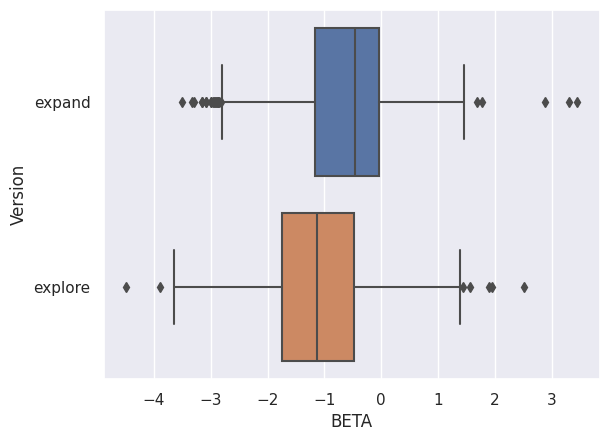

In [80]:
sns.set()
sns.boxplot(data=gene_m, y='Version', x='BETA')

/var/tmp/ipykernel_37954/3570186854.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, x[i], int(np.round(x[i],0)), ha = 'center')


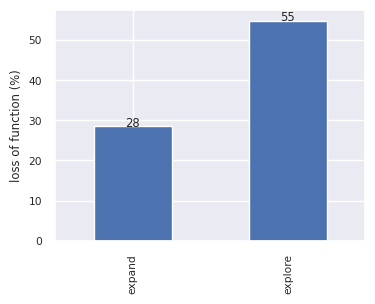

In [81]:
# plot percentage of each dilution factor that is loss-of-function
x = (ver_grp2['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1])

sns.set(font_scale=0.7)
f, ax = plt.subplots(figsize=(4, 3))
x.plot(kind='bar')
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("loss of function (%)") ## Set Y-axis label
for i in range(len(x)):
    plt.text(i, x[i], int(np.round(x[i],0)), ha = 'center')

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='BETA', ylabel='Dilution_factor'>

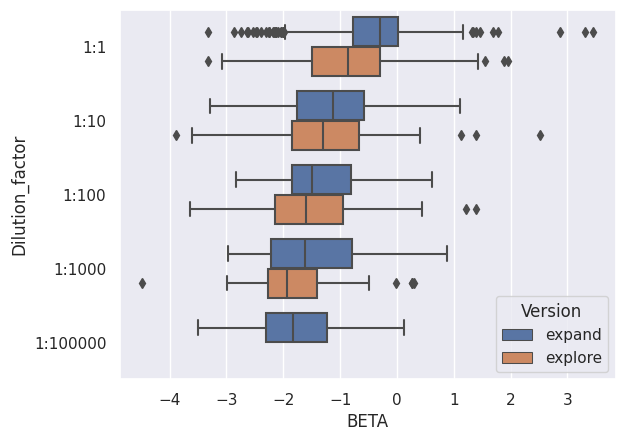

In [82]:
sns.set()
sns.boxplot(data=gene_m, y='Dilution_factor', x='BETA', hue='Version')

In [83]:
gene_m.reset_index(inplace=True)

In [84]:
# Combined field for dilution factor, panel version
gene_m['df_ver'] = gene_m['Dilution_factor'].astype(str) + "," + gene_m['Version'].astype(str)

In [85]:
# Dummy variables for combined dilution factors x panel versions
df_ver = pd.get_dummies(gene_m['df_ver'])
X = df_ver.drop('1:1,expand', axis=1)

In [86]:
# logistic regression model of loss of function classification vs. dilution factor
#X = df_ver
y = gene_m['loss_of_function']
model = LogisticRegression()
model.fit(X,y)

# coef significance
pvals=logit_pvalue(model, X)
df = pd.DataFrame(data=pvals, index=['intercept']+X.columns.tolist())
print(df.sort_values('Estimate'))
print("\n")

                 Estimate  Std_Error      z_val         p_val
intercept       -1.518298   0.083029 -18.286332  0.000000e+00
1:1,explore      1.218560   0.110265  11.051208  0.000000e+00
1:10,expand      1.768697   0.181033   9.770017  0.000000e+00
1:10,explore     2.055000   0.139870  14.692240  0.000000e+00
1:100,expand     2.145071   0.302692   7.086656  1.374012e-12
1:1000,expand    2.191257   0.325933   6.723035  1.779776e-11
1:100,explore    2.529743   0.181244  13.957644  0.000000e+00
1:100000,expand  2.658802   0.293002   9.074337  0.000000e+00
1:1000,explore   3.227867   0.335375   9.624653  0.000000e+00




In [87]:
df_ver = gene_m.groupby('df_ver')
df_ver['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
df_ver,,,,,,,,
"1:1,expand",984.0,-0.399504,0.704173,-3.326060,-0.771366,-0.296894,0.022123,3.448040
"1:1,explore",777.0,-0.880164,0.851061,-3.327210,-1.485870,-0.865540,-0.302620,1.954940
"1:10,expand",157.0,-1.159414,0.856101,-3.293180,-1.764838,-1.130759,-0.578811,1.114730
"1:10,explore",339.0,-1.286173,0.882187,-3.891540,-1.847132,-1.293676,-0.660396,2.508420
"1:100,expand",52.0,-1.310482,0.831931,-2.826368,-1.846358,-1.496027,-0.814510,0.618561
"1:100,explore",197.0,-1.510795,0.866338,-3.640620,-2.137752,-1.604600,-0.945285,1.386150
"1:1000,expand",45.0,-1.479638,0.901428,-2.965304,-2.222962,-1.623421,-0.796814,0.874340
"1:1000,explore",73.0,-1.822549,0.808451,-4.483070,-2.266253,-1.927922,-1.406533,0.291526
"1:100000,expand",69.0,-1.772377,0.815088,-3.498980,-2.295810,-1.825514,-1.227366,0.124111


In [88]:
x = (df_ver['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1])
x

df_ver
1:1,expand         16.158537
1:1,explore        42.728443
1:10,expand        57.324841
1:10,explore       63.716814
1:100,expand       69.230769
1:100,explore      74.619289
1:1000,expand      71.111111
1:1000,explore     89.041096
1:100000,expand    79.710145
Name: proportion, dtype: float64

/var/tmp/ipykernel_37954/2902092120.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, x[i], int(np.round(x[i],0)), ha = 'center')


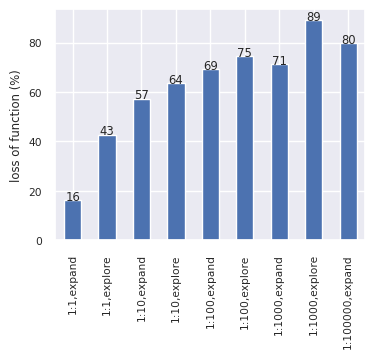

In [89]:
sns.set(font_scale=0.7)
f, ax = plt.subplots(figsize=(4, 3))
x.plot(kind='bar')
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("loss of function (%)") ## Set Y-axis label
for i in range(len(x)):
    plt.text(i, x[i], int(np.round(x[i],0)), ha = 'center')

In [90]:
# confusion matrix / contingency table
pred = model.predict(X)
print(pd.crosstab(y, pred, margins=True))

col_0                0    1   All
loss_of_function                 
0                 1270  291  1561
1                  491  641  1132
All               1761  932  2693


In [91]:
indices = gene_m.loc[gene_m['df_ver']=='1:1,expand',:].index.tolist()
print(pd.crosstab(y[indices], pred[indices], margins=True))
print(sum(pred[indices])/len(pred[indices])*100)

col_0               0  All
loss_of_function          
0                 825  825
1                 159  159
All               984  984
0.0


In [92]:
indices2 = gene_m.loc[gene_m['df_ver']!='1:1,expand',:].index.tolist()
print(pd.crosstab(y[indices2], pred[indices2], margins=True))
print(sum(pred[indices2])/len(pred[indices2])*100)

col_0               0    1   All
loss_of_function                
0                 445  291   736
1                 332  641   973
All               777  932  1709
54.5348156816852


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='BETA', ylabel='Panel'>

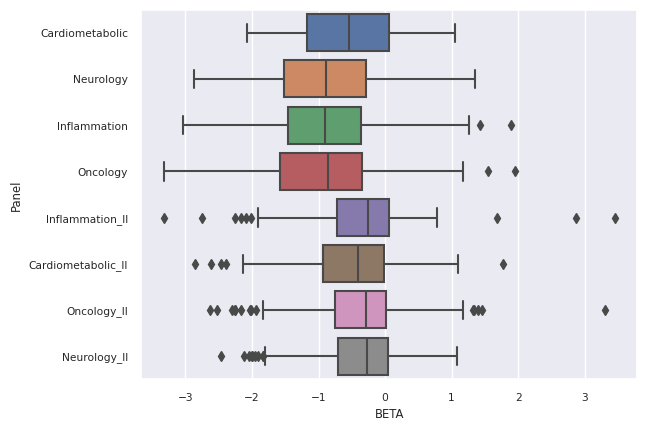

In [93]:
sns.boxplot(data=gene_m.loc[gene_m['Dilution_factor']=='1:1',:], y='Panel', x='BETA')

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='BETA', ylabel='Panel'>

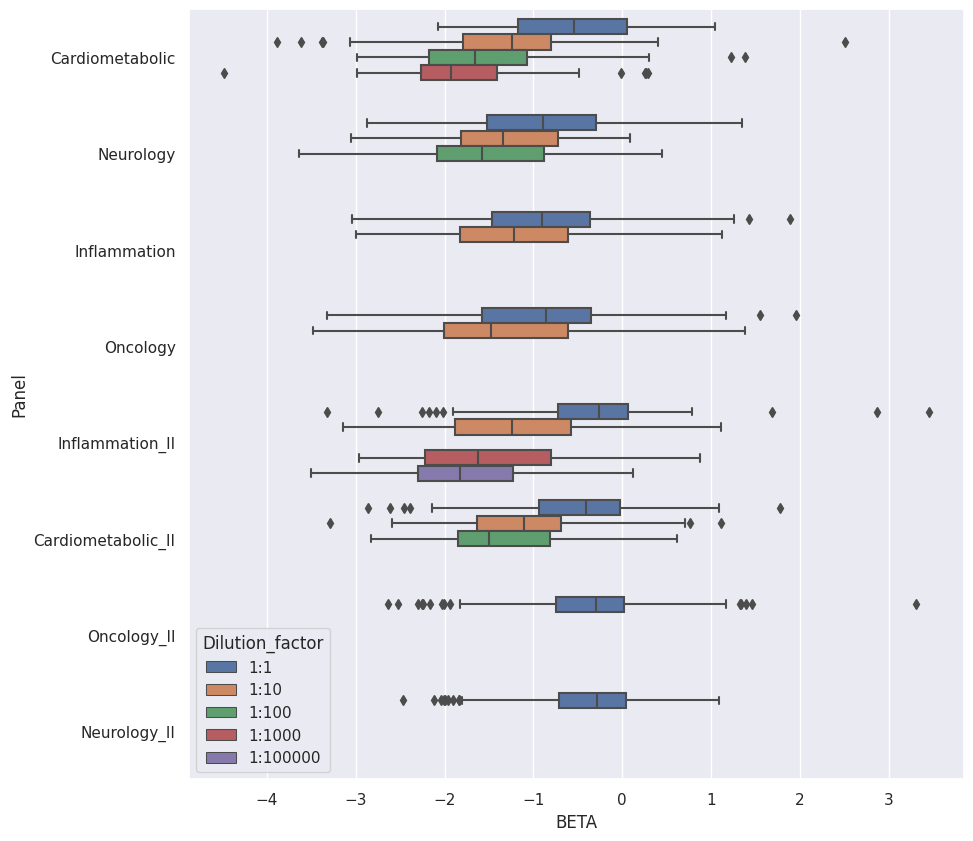

In [94]:
sns.set()
f, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(data=gene_m, y='Panel', x='BETA', hue='Dilution_factor')

## Missingness

In [95]:
# Read in olink assay NPX results to assess missingness for each protein
# npx = pd.read_csv('/home/jupyter/gcs/ukb/regenie/phenotype_bin.txt', sep='\t')

In [96]:
# prots = npx.columns.tolist()
# prots2 = prots[2:]

In [97]:
# prots3 = [x[:-5].upper() for x in prots2]

In [98]:
# col_dict = {prots2[i]: prots3[i] for i in range(len(prots2))}

In [99]:
# npx.drop(['FID','IID'], axis=1, inplace=True)
# npx.rename(col_dict, axis=1, inplace=True)

In [100]:
# def missing(col):
#     return sum(pd.isna(col))

# def pct_missing(col):
#     return 100*sum(pd.isna(col))/len(col)

In [101]:
# miss_cnt = pd.Series(npx.apply(missing), name="miss_cnt")
# miss_pct = pd.Series(npx.apply(pct_missing), name="miss_pct")

In [102]:
# missingness = pd.concat([miss_cnt, miss_pct], axis=1)

In [103]:
# # merge gene df with missingness table
# gene_m2 = pd.merge(missingness, gene_m, how='inner', left_index=True, right_on='symbol')

In [104]:
# # export merged dataframe for easier use later
# gene_m2.to_csv('/home/jupyter/gcs/ukb/regenie/gwas_annotated/genes_olink.txt', sep='\t')

In [105]:
# read in saved merged dataframe
gene_m2 = pd.read_csv('/home/jupyter/gcs/ukb/regenie/gwas_annotated/genes_olink.txt', sep='\t')

<Axes: xlabel='miss_pct', ylabel='BETA'>

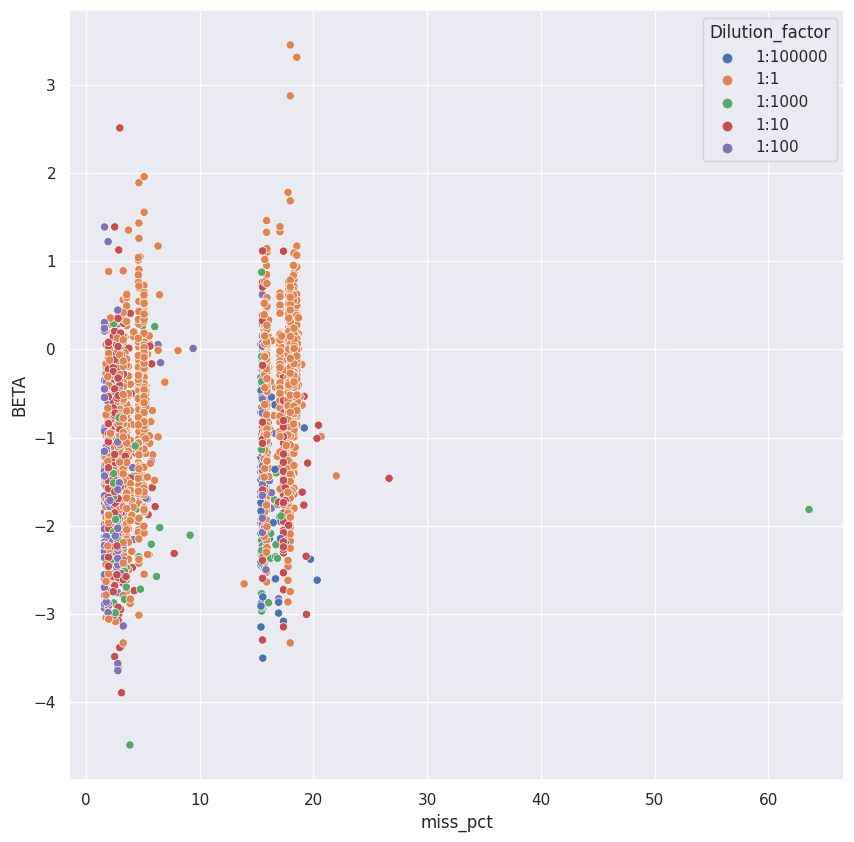

In [106]:
f, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=gene_m2, x='miss_pct', y='BETA', hue='Dilution_factor')

In [107]:
gene_m2.loc[gene_m2['miss_pct']>25,['symbol','miss_pct','BETA','olink_target_fullname','UniProt','ensembl_id','chr','Dilution_factor','Version']]

,symbol,miss_pct,BETA,olink_target_fullname,UniProt,ensembl_id,chr,Dilution_factor,Version
657,CST1,26.657487,-1.461400,Cystatin-SN,P01037,ENSG00000170373,20,1:10,expand
1844,PCOLCE,63.585265,-1.815428,Procollagen C-endopeptidase enhancer 1,Q15113,ENSG00000106333,7,1:1000,explore


In [108]:
QC3 = pd.Series(gene_m2.loc[gene_m2['miss_pct']>25,'symbol'])
QC3.to_csv('/home/jupyter/gcs/ukb/QC/QC3.txt', sep='\n', index=False, header=False)

<Axes: xlabel='miss_cnt', ylabel='BETA'>

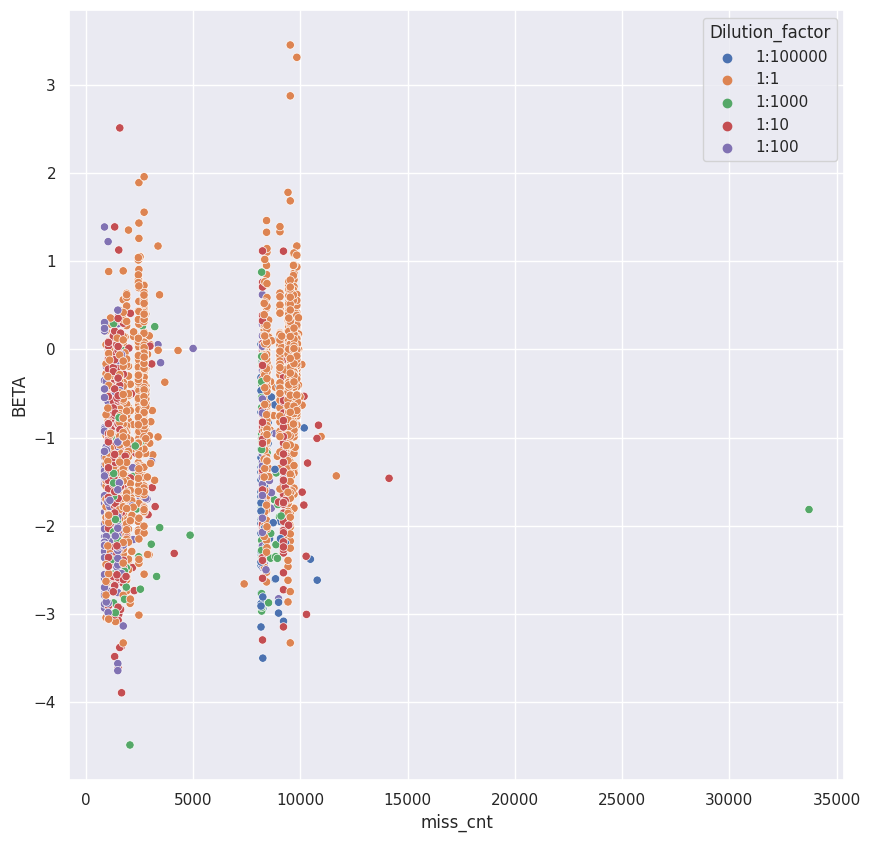

In [109]:
f, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=gene_m2, x='miss_cnt', y='BETA', hue='Dilution_factor')

In [110]:
# Gene count and mean beta breakdown by version
ver_grp2 = gene_m2.groupby('Version')
sorted_grp = ver_grp2['BETA'].median().sort_values()
custom_order = sorted_grp.index.tolist()
gene_m2['Version'] = pd.Categorical(gene_m2['Version'].astype(str), categories=custom_order, ordered=True)
ver_grp2 = gene_m2.groupby('Version', observed=True)
ver_grp2['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
Version,,,,,,,,
explore,1386.0,-1.118739,0.90703,-4.48307,-1.749918,-1.125107,-0.481941,2.50842
expand,1307.0,-0.636697,0.85773,-3.49898,-1.157365,-0.462972,-0.048838,3.44804


<Axes: xlabel='miss_pct', ylabel='BETA'>

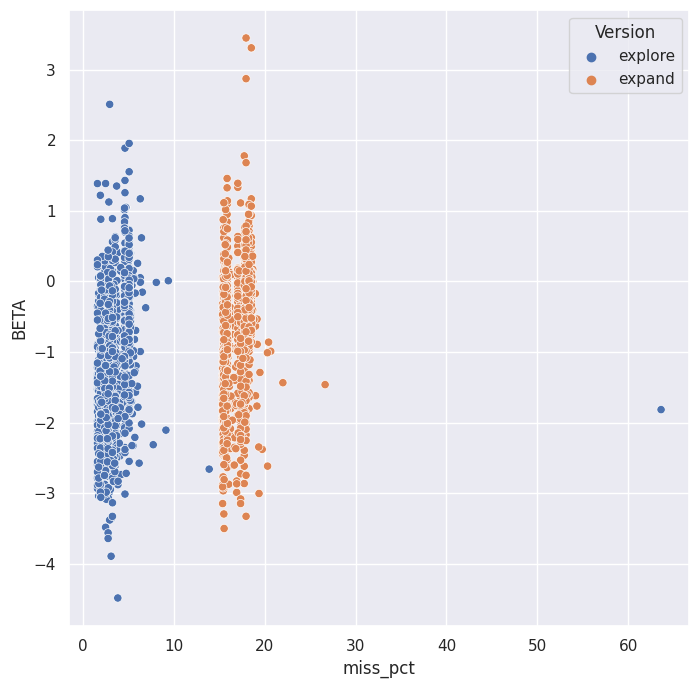

In [111]:
f, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=gene_m2, x='miss_pct', y='BETA', hue='Version')

In [112]:
gene_m2.groupby('Version')['miss_pct'].describe()

/var/tmp/ipykernel_37954/2897708125.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gene_m2.groupby('Version')['miss_pct'].describe()


,count,mean,std,min,25%,50%,75%,max
Version,,,,,,,,
explore,1386.0,3.418550,2.021236,1.631552,2.529377,2.974518,4.609842,63.585265
expand,1307.0,17.068669,1.193536,15.395062,15.802478,17.368014,17.967822,26.657487


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='miss_pct', ylabel='Density'>

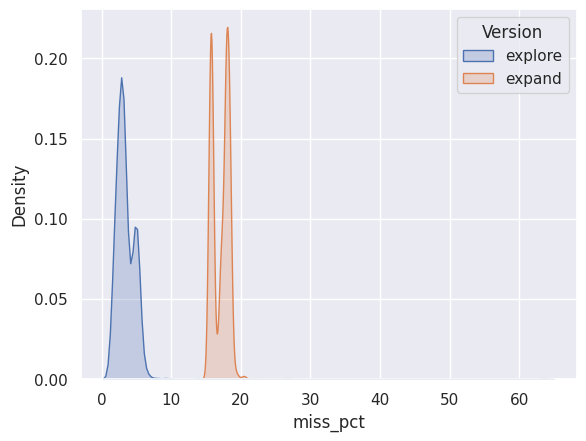

In [113]:
sns.kdeplot(data=gene_m2, x='miss_pct', hue='Version', fill=True)

In [114]:
expand = gene_m2.loc[gene_m2['Version']=='expand',:]
explore = gene_m2.loc[gene_m2['Version']=='explore',:]

In [115]:
expand.groupby('Dilution_factor')['miss_pct'].describe()

,count,mean,std,min,25%,50%,75%,max
Dilution_factor,,,,,,,,
1:1,984.0,17.313261,1.081939,15.676104,15.919422,17.839561,18.245091,22.015580
1:10,157.0,16.766561,1.383462,15.528981,15.528981,17.368014,17.368014,26.657487
1:100,52.0,15.707879,0.502172,15.517664,15.517664,15.517664,15.517664,17.864081
1:1000,45.0,15.850639,0.646744,15.453534,15.453534,15.453534,16.059000,18.260181
1:100000,69.0,16.087867,1.065997,15.395062,15.395062,15.555388,16.617311,20.336873


In [116]:
explore.groupby('Dilution_factor')['miss_pct'].describe()

,count,mean,std,min,25%,50%,75%,max
Dilution_factor,,,,,,,,
1:1,777.0,3.860778,1.220951,1.767358,2.970745,3.742196,5.105909,13.914405
1:10,339.0,2.758324,0.647543,1.978611,2.408661,2.727427,2.887753,7.763548
1:100,197.0,2.559786,0.973998,1.631552,1.631552,2.804761,2.804761,9.425279
1:1000,73.0,4.095016,7.164137,2.278514,2.438840,2.753834,3.391365,63.585265


<Axes: xlabel='miss_pct', ylabel='BETA'>

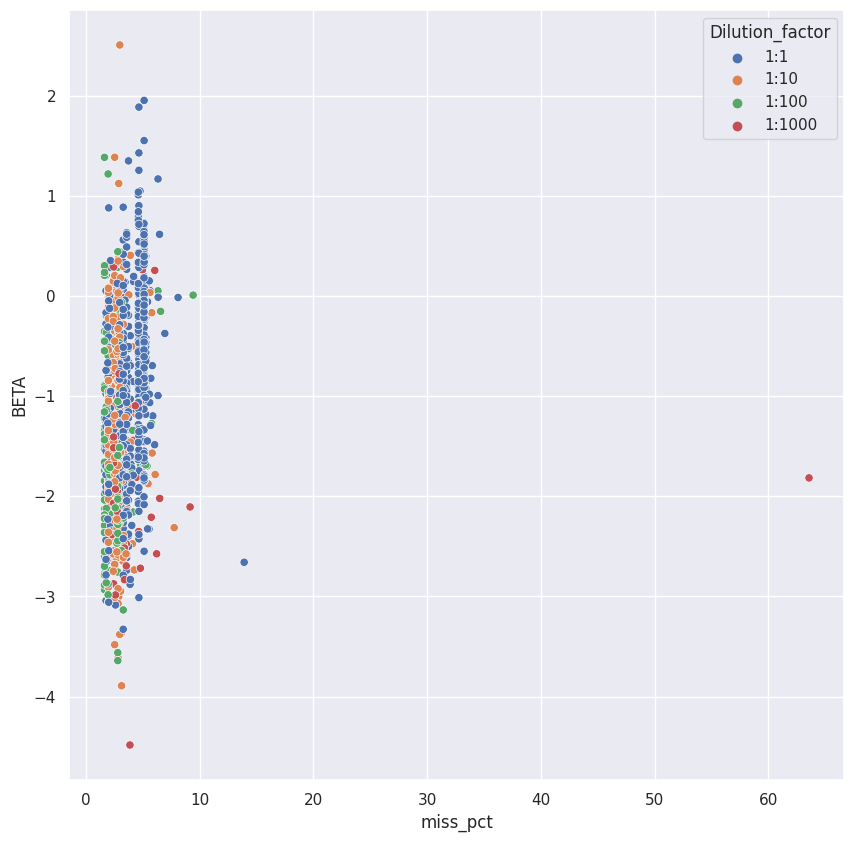

In [117]:
f, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=explore, x='miss_pct', y='BETA', hue='Dilution_factor')

<Axes: xlabel='miss_pct', ylabel='BETA'>

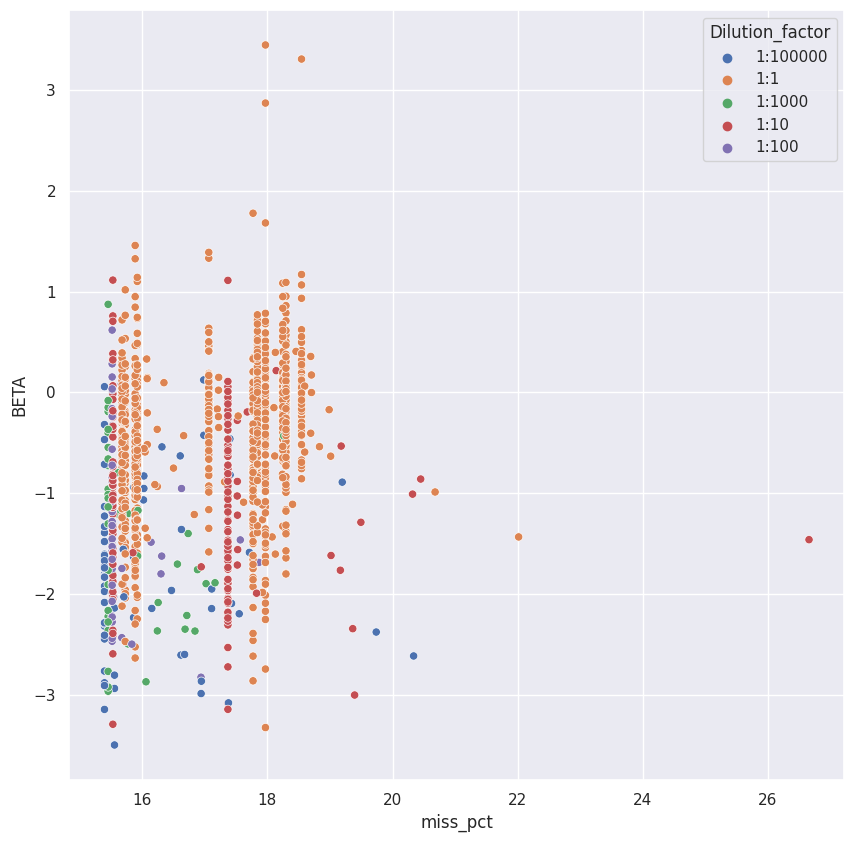

In [118]:
f, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=expand, x='miss_pct', y='BETA', hue='Dilution_factor')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='miss_pct', ylabel='Dilution_factor'>

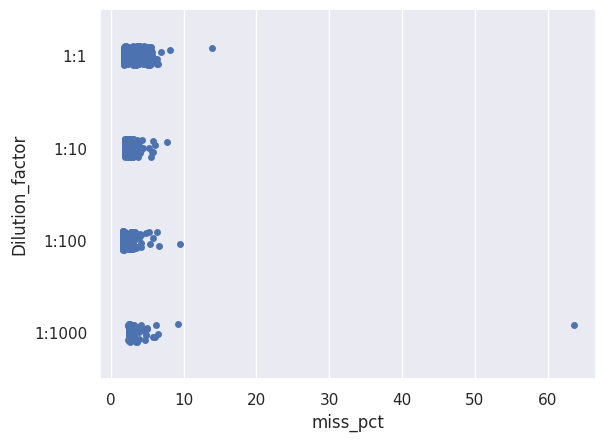

In [119]:
sns.stripplot(data=explore, x='miss_pct', y='Dilution_factor')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='miss_pct', ylabel='Dilution_factor'>

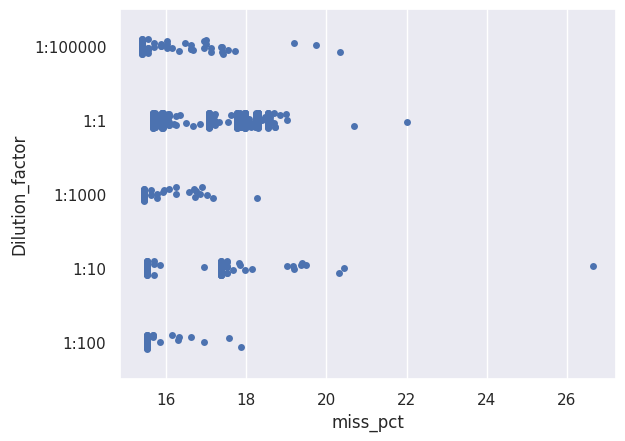

In [120]:
sns.stripplot(data=expand, x='miss_pct', y='Dilution_factor')

In [121]:
# logistic regression model of loss of function classification vs. missingness
X = pd.DataFrame(explore.loc[explore['Dilution_factor']=="1:1",'miss_cnt'])
y = explore.loc[explore['Dilution_factor']=="1:1",'loss_of_function']
model = LogisticRegression()
model.fit(X,y)

# coef significance
pvals=logit_pvalue(model, X)
df = pd.DataFrame(data=pvals, index=['intercept']+X.columns.tolist())
print(df.sort_values('Estimate'))
print("\n")

# confusion matrix / contingency table
pred = model.predict(X)
print(pd.crosstab(y, pred, margins=True))

# Evaluation metrics for default threshold 
print("\nEvaluation metrics with threshold 0.5:") 
assess_pred(y, pred)

           Estimate  Std_Error     z_val         p_val
miss_cnt  -0.001048   0.000128 -8.178297  2.220446e-16
intercept  1.821586   0.266882  6.825432  8.766099e-12


col_0               0    1  All
loss_of_function               
0                 305  140  445
1                 152  180  332
All               457  320  777

Evaluation metrics with threshold 0.5:
Total: 777
Correct predictions (accuracy): 485 (62.4%)
TPR (recall/sensitivity)=TP/P: 54.2%
TNR (specificity)=TN/N: 68.5%
PPV (precision)=TP/(TP+FP): 56.2%
FDR (false discovery)=1-PPV: 43.8%
FPR (false positive rate)=FP/N=1-TNR: 31.5%
F1 score: 55.2%
OR (odds ratio)=(TP/FP)/(FN/TN): 2.58
Fisher exact test p-value: 1.4050812425723964e-10


In [122]:
# logistic regression model of loss of function classification vs. olink panel
X = pd.DataFrame(explore.loc[explore['Dilution_factor']=="1:1",'miss_cnt'])
y = explore.loc[explore['Dilution_factor']=="1:1",'BETA']
model = LinearRegression()
model.fit(X,y)

LinearRegression()

In [123]:
model.score(X, y)

0.09709865053180544

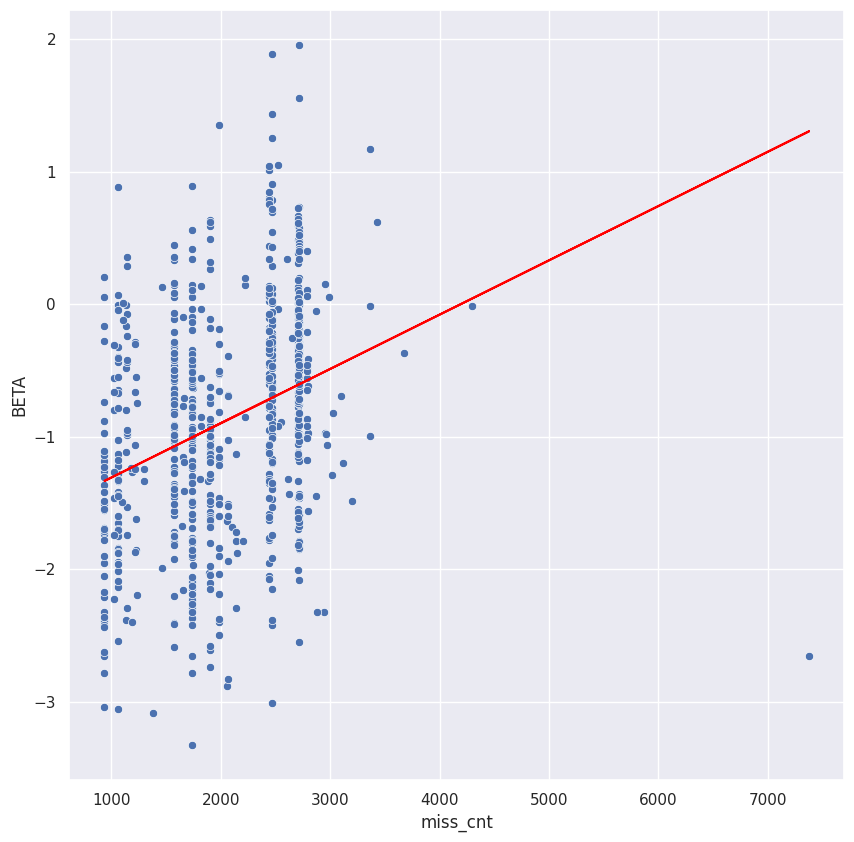

In [124]:
f, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=explore.loc[explore['Dilution_factor']=="1:1",:], x='miss_cnt', y='BETA')
pred = model.predict(X)
ax.plot(X,pred, color='red')